### Import required packages and limit GPU usage

In [1]:
import numpy as np
import math
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

import pickle
import argparse
import time
import itertools
from copy import deepcopy
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import csv

# Import the module
import networks
import utils
from quantize_neural_net import QuantizeNeuralNet

%load_ext autoreload
%autoreload 2

In [2]:
use_gpu = True    # set use_gpu to True if system has gpu
gpu_id = 0        # id of gpu to be used
cpu_device = torch.device('cpu')
# fast_device is where computation (training, inference) happens
fast_device = torch.device('cpu')
if use_gpu:
    os.environ['CUDA_VISIBLE_DEVICES'] = '0,1,2'    # set visible devices depending on system configuration
    fast_device = torch.device('cuda:' + str(gpu_id))

In [3]:
def reproducibilitySeed():
    """
    Ensure reproducibility of results; Seeds to 0
    """
    torch_init_seed = 0
    torch.manual_seed(torch_init_seed)
    numpy_init_seed = 0
    np.random.seed(numpy_init_seed)
    if use_gpu:
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

reproducibilitySeed()

In [4]:
checkpoints_path_teacher = 'checkpoints_teacher/'
checkpoints_path_student_nokd = 'checkpoints_student/checkpoints_student_NoKD/'
checkpoints_path_student_van = 'checkpoints_student/checkpoints_student_VAN/'
checkpoints_path_student_qat = 'checkpoints_student/checkpoints_student_QAT/'
checkpoints_path_student_dml = 'checkpoints_student/checkpoints_student_DML/'
if not os.path.exists(checkpoints_path_teacher):
    os.makedirs(checkpoints_path_teacher)
if not os.path.exists(checkpoints_path_student_nokd):
    os.makedirs(checkpoints_path_student_nokd)
if not os.path.exists(checkpoints_path_student_van):
    os.makedirs(checkpoints_path_student_van)
if not os.path.exists(checkpoints_path_student_qat):
    os.makedirs(checkpoints_path_student_qat)
if not os.path.exists(checkpoints_path_student_dml):
    os.makedirs(checkpoints_path_student_dml)

### Load dataset

In [5]:
import torchvision
import torchvision.transforms as transforms
import PIL

# Set up transformations for CIFAR-10
transform_train = transforms.Compose(
    [
        #transforms.RandomCrop(32, padding=4),  # Augment training data by padding 4 and random cropping
        transforms.RandomHorizontalFlip(),     # Randomly flip images horizontally
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))  # Normalization for CIFAR-10
    ]
)

transform_test = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))  # Normalization for CIFAR-10
    ]
)

import torchvision as tv
preprocess_train = tv.transforms.Compose([
    tv.transforms.Resize((160, 160), interpolation=PIL.Image.BILINEAR),  # It's the default, just being explicit for the reader.
    tv.transforms.RandomCrop((128, 128)),
    tv.transforms.RandomHorizontalFlip(),
    tv.transforms.ToTensor(),
    tv.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))  # Normalization for CIFAR-10
])

preprocess_eval = tv.transforms.Compose([
    tv.transforms.Resize((128, 128), interpolation=PIL.Image.BILINEAR),
    tv.transforms.ToTensor(),
    tv.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))  # Normalization for CIFAR-10
])

# Load CIFAR-10 dataset
train_val_dataset = torchvision.datasets.CIFAR10(root='./CIFAR10_dataset/', train=True,
                                            download=True, transform=transform_train)

test_dataset = torchvision.datasets.CIFAR10(root='./CIFAR10_dataset/', train=False,
                                            download=True, transform=transform_test)

# Split the training dataset into training and validation
num_train = int(0.95 * len(train_val_dataset))  # 95% of the dataset for training
num_val = len(train_val_dataset) - num_train  # Remaining 5% for validation
train_dataset, val_dataset = torch.utils.data.random_split(train_val_dataset, [num_train, num_val])

# DataLoader setup
batch_size = 128
train_val_loader = torch.utils.data.DataLoader(train_val_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
def count_parameters(model):
    """
    Counts the total number of trainable parameters in a PyTorch model.

    Args:
        model (torch.nn.Module): The model whose parameters need to be counted.

    Returns:
        int: Total number of trainable parameters.
    """
    return sum((p.data != 0).sum().item() for p in model.parameters() if p.requires_grad)


def count_zero_parameters(model):
    """
    Counts the number of trainable parameters that are exactly zero in a PyTorch model.

    Args:
        model (torch.nn.Module): The model whose zero parameters need to be counted.

    Returns:
        int: Total number of trainable parameters that are exactly zero.
    """
    return sum((p.data == 0).sum().item() for p in model.parameters() if p.requires_grad)

In [7]:
def calculate_bit_size(model):
    """
    Calculate the effective bit size of a quantized model.
    
    Parameters:
        model: nn.Module
            The quantized neural network model.
    
    Returns:
        float: The average bit size across all layers.
    """
    total_bits = 0
    total_params = 0
    
    for name, param in model.named_parameters():
        if param.requires_grad:
            # Calculate unique values and their count
            unique_values = torch.unique(param.data).cpu().numpy()
            num_unique_values = len(unique_values)
            
            # Calculate bit size for this layer
            layer_bits = np.ceil(np.log2(num_unique_values)) if num_unique_values > 1 else 1
            total_bits += layer_bits * param.numel()
            total_params += param.numel()
    
    # Return average bit size across all parameters
    return total_bits / total_params if total_params > 0 else 0


## Teacher Model

### load pre-trained teacher model

In [8]:
import detectors
import timm

teacher_net = timm.create_model("resnet50_cifar10", pretrained=True)

teacher_net = teacher_net.to(fast_device)
# pre-trained teacher accuracy
reproducibilitySeed()
_, test_accuracy = utils.getLossAccuracyOnDataset(teacher_net, test_loader, fast_device)
print('test accuracy: ', test_accuracy)


c:\Users\17598\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


test accuracy:  0.9225


In [9]:
# another way load teacher
teacher_net = networks.TeacherNetwork50()

checkpoint = torch.load('resnet50_cifar10_pretrained.bin')

teacher_net.model.load_state_dict(checkpoint)
teacher_net.to(fast_device)

reproducibilitySeed()
_, test_accuracy = utils.getLossAccuracyOnDataset(teacher_net, test_loader, fast_device)
print('test accuracy: ', test_accuracy)

c:\Users\17598\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\17598\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\17598\AppData\Local\Temp\ipykernel_9552\1025170478.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickli

test accuracy:  0.9225


### Quantized Teacher Model

In [25]:
# Quantization CSV file setup
csv_file = "checkpoints_teacher/results_teacher_quantization.csv"
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Bits", "Effective Bits", "Original Test Accuracy", "Quantized Test Accuracy", "Sparsity", "Training Time (s)"])

In [10]:
csv_file = "checkpoints_teacher/results_teacher_quantization.csv"
bits_list = range(32, 0, -1)  # 2, 4, ..., 30

for bits in bits_list:
    # Quantization process
    quantizer = QuantizeNeuralNet(
        teacher_net.model,
        'resnet50',
        batch_size=128,
        data_loader=train_loader,
        mlp_bits=bits,
        cnn_bits=bits,
        ignore_layers=[],
        mlp_alphabet_scalar=2.5,
        cnn_alphabet_scalar=2.5,
        mlp_percentile=1,
        cnn_percentile=1,
        reg=None,
        lamb=0.1,
        retain_rate=0.25,
        stochastic_quantization=False,
        device=fast_device
    )
    
    # Measure training time
    start_time = time.time()

    quantized_model = quantizer.quantize_network(False)

    training_time = time.time() - start_time

    # Check quantized model bit size
    effective_bit_size = calculate_bit_size(quantized_model)
    print(f"Bits {bits}, Effective Quantized Bit Size: {effective_bit_size}")

    _, quantized_test_accuracy = utils.getLossAccuracyOnDataset(quantized_model, test_loader, fast_device)
    print(f"Bits {bits}, Quantized Test Accuracy: {quantized_test_accuracy}")

    parameter = count_parameters(quantized_model) 
    sparsity = utils.eval_sparsity(quantized_model)

    # Write results to CSV
    with open(csv_file, mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([
            bits, effective_bit_size, 0.9225, quantized_test_accuracy, sparsity,  training_time  # Include effective bit size
        ])

print(f"Results saved to {csv_file}")

The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 359.13it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 230.27it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 3190.07it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 188.66it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 187.89it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 393.51it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 3035.53it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 192.01it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 429.54it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 3208.54it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 192.81it/s]


The number of groups: 1



100%|██████████| 256/256 [00:01<00:00, 218.80it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2399.74it/s]


The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 669.23it/s]


The number of groups: 1



100%|██████████| 256/256 [00:04<00:00, 60.01it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1747.24it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3477.26it/s]


The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 668.14it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1737.63it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3217.32it/s]


The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 666.15it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1721.99it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3265.65it/s]


The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 682.42it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1081.45it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2817.86it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1168.70it/s]


The number of groups: 1



100%|██████████| 512/512 [00:01<00:00, 340.89it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2488.47it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3220.94it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1229.95it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2421.25it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3844.48it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1176.00it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2336.35it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3720.24it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1181.02it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2509.90it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3876.73it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1191.92it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2484.35it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3633.90it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1119.34it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 1764.68it/s]


The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3301.26it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1710.49it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:01<00:00, 662.63it/s]


The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 3110.91it/s]


The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3996.96it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1775.69it/s]


The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 3203.47it/s]


The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3598.33it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1755.85it/s]


The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 4056.17it/s]


Bits 32, Effective Quantized Bit Size: 20.15888002648885
Bits 32, Quantized Test Accuracy: 0.9241
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 328.00it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 171.14it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2761.55it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 185.11it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 184.88it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 376.16it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 3013.35it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 182.84it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 424.29it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 3298.49it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 190.30it/s]


The number of groups: 1



100%|██████████| 256/256 [00:01<00:00, 217.67it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2395.42it/s]


The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 684.11it/s]


The number of groups: 1



100%|██████████| 256/256 [00:04<00:00, 60.30it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1733.92it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3606.02it/s]


The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 689.61it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1599.98it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3397.49it/s]


The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 687.10it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1722.50it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3404.20it/s]


The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 693.72it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1100.68it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3129.36it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1151.12it/s]


The number of groups: 1



100%|██████████| 512/512 [00:01<00:00, 341.83it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2461.47it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3731.79it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1149.59it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2451.72it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3832.37it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1189.32it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2085.31it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3657.04it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1184.47it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2185.15it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3341.54it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1086.21it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2414.24it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3711.94it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1155.23it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 1752.02it/s]


The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3370.86it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1741.41it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:01<00:00, 671.06it/s]


The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 2983.24it/s]


The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3950.51it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1833.06it/s]


The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 3198.04it/s]


The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3867.29it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1824.81it/s]


The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 3929.80it/s]


Bits 31, Effective Quantized Bit Size: 20.15888002648885
Bits 31, Quantized Test Accuracy: 0.9227
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 349.05it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 183.39it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 3024.08it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 185.02it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 192.68it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 435.94it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 3138.80it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 191.52it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 429.44it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 3045.36it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 190.27it/s]


The number of groups: 1



100%|██████████| 256/256 [00:01<00:00, 229.50it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2453.58it/s]


The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 623.54it/s]


The number of groups: 1



100%|██████████| 256/256 [00:04<00:00, 60.89it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1756.56it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3455.06it/s]


The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 693.07it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1831.78it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3369.76it/s]


The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 666.09it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1823.01it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3504.19it/s]


The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 686.60it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1112.00it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3162.40it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1194.96it/s]


The number of groups: 1



100%|██████████| 512/512 [00:01<00:00, 340.97it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2666.99it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 4010.98it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1204.88it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2590.32it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3424.81it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1205.94it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2544.84it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3856.65it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1156.59it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2534.13it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3984.95it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1254.27it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2537.71it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3771.26it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1246.22it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 1690.26it/s]


The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3613.06it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1700.26it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:01<00:00, 659.19it/s]


The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 3165.48it/s]


The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3974.22it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1650.28it/s]


The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 2896.11it/s]


The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3943.70it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1789.00it/s]


The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 4205.64it/s]


Bits 30, Effective Quantized Bit Size: 20.15888002648885
Bits 30, Quantized Test Accuracy: 0.9239
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 428.36it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 232.64it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 3155.55it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 193.14it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 192.00it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 440.43it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 3475.68it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 190.51it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 428.39it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 3264.58it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 190.22it/s]


The number of groups: 1



100%|██████████| 256/256 [00:01<00:00, 228.21it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2526.45it/s]


The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 695.82it/s]


The number of groups: 1



100%|██████████| 256/256 [00:04<00:00, 60.35it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1803.13it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3386.26it/s]


The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 684.01it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1788.23it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3790.47it/s]


The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 666.98it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1705.63it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3415.84it/s]


The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 626.48it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1099.44it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3263.58it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1215.79it/s]


The number of groups: 1



100%|██████████| 512/512 [00:01<00:00, 343.49it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2477.30it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3902.89it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1244.22it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2496.87it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3828.08it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1245.94it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2538.64it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3948.48it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1165.27it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2436.44it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3292.54it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1239.23it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2492.90it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3962.59it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1205.20it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 1773.29it/s]


The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3506.10it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1810.09it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:01<00:00, 671.59it/s]


The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 3375.49it/s]


The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3971.71it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1788.30it/s]


The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 3021.25it/s]


The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3848.75it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1820.29it/s]


The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 4109.57it/s]


Bits 29, Effective Quantized Bit Size: 20.15888002648885
Bits 29, Quantized Test Accuracy: 0.9225
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 411.07it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 235.53it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 3156.04it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 193.77it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 194.30it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 427.44it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 3093.22it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 191.27it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 433.51it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 3040.95it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 191.64it/s]


The number of groups: 1



100%|██████████| 256/256 [00:01<00:00, 230.98it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2283.76it/s]


The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 675.26it/s]


The number of groups: 1



100%|██████████| 256/256 [00:04<00:00, 60.70it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1660.75it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3568.87it/s]


The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 665.67it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1777.34it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3547.75it/s]


The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 719.81it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1753.41it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3499.51it/s]


The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 675.96it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1138.39it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3164.24it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1237.25it/s]


The number of groups: 1



100%|██████████| 512/512 [00:01<00:00, 347.72it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2536.00it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3902.32it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1196.52it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2191.16it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3893.15it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1283.15it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2600.55it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3665.74it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1190.57it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2600.21it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3995.12it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1216.30it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2535.14it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 4068.48it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 952.90it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 1736.00it/s]


The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3278.94it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1803.89it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:01<00:00, 635.42it/s]


The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 3155.25it/s]


The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3858.87it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1749.95it/s]


The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 3262.25it/s]


The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 4068.70it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1657.14it/s]


The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 3406.47it/s]


Bits 28, Effective Quantized Bit Size: 20.15888002648885
Bits 28, Quantized Test Accuracy: 0.9235
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 324.86it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 216.79it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2789.06it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 172.67it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 188.58it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 423.09it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 3290.83it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 194.93it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 430.53it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2807.72it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 194.46it/s]


The number of groups: 1



100%|██████████| 256/256 [00:01<00:00, 225.44it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2241.14it/s]


The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 655.68it/s]


The number of groups: 1



100%|██████████| 256/256 [00:04<00:00, 60.25it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1704.70it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2792.67it/s]


The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 685.74it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1776.91it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3837.01it/s]


The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 677.79it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1743.62it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3465.64it/s]


The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 597.73it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1072.04it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3113.76it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1126.61it/s]


The number of groups: 1



100%|██████████| 512/512 [00:01<00:00, 334.14it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2574.63it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3954.35it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1205.85it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2582.89it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3819.65it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1248.13it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2543.28it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 4046.82it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1216.38it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2452.33it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3563.78it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1212.82it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2506.60it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 4025.53it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1177.62it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 1699.26it/s]


The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3430.17it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1776.59it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:01<00:00, 667.45it/s]


The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 3211.72it/s]


The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 4081.21it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1664.92it/s]


The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 3042.88it/s]


The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3963.89it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1825.12it/s]


The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 4227.16it/s]


Bits 27, Effective Quantized Bit Size: 20.15888002648885
Bits 27, Quantized Test Accuracy: 0.9228
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 379.40it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 199.44it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 3061.09it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 191.04it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 191.71it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 432.53it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 3333.01it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 192.51it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 441.85it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 3224.22it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 193.66it/s]


The number of groups: 1



100%|██████████| 256/256 [00:01<00:00, 229.80it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2481.93it/s]


The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 627.87it/s]


The number of groups: 1



100%|██████████| 256/256 [00:04<00:00, 60.33it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1789.81it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3517.12it/s]


The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 646.58it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1806.32it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3324.06it/s]


The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 680.11it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1559.68it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3387.81it/s]


The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 672.13it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1111.97it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3157.56it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1161.95it/s]


The number of groups: 1



100%|██████████| 512/512 [00:01<00:00, 338.89it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2539.81it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3894.51it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1213.84it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2284.29it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3882.20it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1178.56it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2618.02it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3687.60it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1200.14it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2441.06it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3835.90it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1282.25it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2542.13it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 4049.68it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1084.13it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 1785.88it/s]


The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3530.11it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1712.66it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:01<00:00, 648.33it/s]


The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 3119.89it/s]


The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3950.79it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1665.04it/s]


The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 3246.16it/s]


The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3922.74it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1827.46it/s]


The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 4078.86it/s]


Bits 26, Effective Quantized Bit Size: 19.857960186969496
Bits 26, Quantized Test Accuracy: 0.9229
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 328.31it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 216.61it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2832.72it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 193.62it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 187.41it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 425.52it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 3360.09it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 186.20it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 430.43it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2989.24it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 190.39it/s]


The number of groups: 1



100%|██████████| 256/256 [00:01<00:00, 221.75it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2470.60it/s]


The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 563.43it/s]


The number of groups: 1



100%|██████████| 256/256 [00:04<00:00, 60.67it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1785.08it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3427.15it/s]


The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 685.68it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1776.74it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3539.58it/s]


The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 652.19it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1773.68it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3682.12it/s]


The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 663.75it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1107.54it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2952.84it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1156.32it/s]


The number of groups: 1



100%|██████████| 512/512 [00:01<00:00, 341.31it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2583.23it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3749.16it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1238.71it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2565.86it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 4022.87it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1137.44it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2477.57it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3613.70it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1183.79it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2461.71it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3601.37it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1201.89it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2520.63it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3775.90it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1249.42it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 1793.76it/s]


The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3655.66it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1628.45it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:01<00:00, 658.96it/s]


The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 3379.55it/s]


The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3846.37it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1813.69it/s]


The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 3215.36it/s]


The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3803.23it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1723.08it/s]


The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 3953.09it/s]


Bits 25, Effective Quantized Bit Size: 19.857960186969496
Bits 25, Quantized Test Accuracy: 0.9231
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 373.92it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 195.01it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2851.40it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 187.25it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 194.96it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 434.39it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 3086.57it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 194.31it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 430.45it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 3057.22it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 181.37it/s]


The number of groups: 1



100%|██████████| 256/256 [00:01<00:00, 227.97it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2444.37it/s]


The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 630.65it/s]


The number of groups: 1



100%|██████████| 256/256 [00:04<00:00, 60.77it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1830.58it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3485.44it/s]


The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 592.73it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1739.15it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3491.29it/s]


The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 637.90it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1761.89it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3461.46it/s]


The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 715.88it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 991.79it/s] 


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3196.12it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1284.61it/s]


The number of groups: 1



100%|██████████| 512/512 [00:01<00:00, 341.67it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2296.79it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3775.95it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1200.93it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2422.33it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3667.49it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 980.88it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2392.14it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3644.05it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1129.81it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2426.34it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3357.90it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1200.96it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2507.42it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3672.37it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1151.08it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 1618.47it/s]


The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3287.96it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1783.35it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:01<00:00, 649.05it/s]


The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 3000.71it/s]


The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3866.01it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1776.60it/s]


The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 2926.37it/s]


The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3856.47it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1798.14it/s]


The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 4036.92it/s]


Bits 24, Effective Quantized Bit Size: 19.70750026720982
Bits 24, Quantized Test Accuracy: 0.9227
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 343.13it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 243.64it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 3078.71it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 191.46it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 192.29it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 431.27it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 3110.08it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 180.65it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 444.36it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 3346.13it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 195.48it/s]


The number of groups: 1



100%|██████████| 256/256 [00:01<00:00, 228.30it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2216.65it/s]


The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 690.59it/s]


The number of groups: 1



100%|██████████| 256/256 [00:04<00:00, 60.69it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1832.06it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3565.55it/s]


The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 668.28it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1791.41it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3459.36it/s]


The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 685.59it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1626.07it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3312.37it/s]


The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 632.84it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1135.90it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3205.92it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1169.77it/s]


The number of groups: 1



100%|██████████| 512/512 [00:01<00:00, 343.47it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2545.62it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3813.96it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1213.18it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2378.28it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3857.19it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1244.73it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2505.39it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3802.99it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1068.17it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2543.15it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 4056.83it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1169.95it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2587.54it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3765.12it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1229.32it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 1868.31it/s]


The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3475.97it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1713.38it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:01<00:00, 657.05it/s]


The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 3334.45it/s]


The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3977.01it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1760.66it/s]


The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 3367.30it/s]


The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3975.79it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1811.01it/s]


The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 3672.11it/s]


Bits 23, Effective Quantized Bit Size: 19.31741899375881
Bits 23, Quantized Test Accuracy: 0.9232
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 310.94it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 239.26it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2937.63it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 185.48it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 191.61it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 423.99it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 3084.12it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 196.24it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 436.09it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 3091.19it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 191.26it/s]


The number of groups: 1



100%|██████████| 256/256 [00:01<00:00, 226.80it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1991.98it/s]


The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 677.23it/s]


The number of groups: 1



100%|██████████| 256/256 [00:04<00:00, 60.56it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1846.85it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3375.59it/s]


The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 665.64it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1776.56it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3555.23it/s]


The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 619.60it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1776.16it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3550.91it/s]


The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 717.70it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1116.38it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3164.58it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1022.31it/s]


The number of groups: 1



100%|██████████| 512/512 [00:01<00:00, 344.24it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2471.00it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3911.77it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1167.04it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2519.53it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3953.77it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1229.13it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2484.50it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3854.53it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1156.96it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2478.21it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3960.46it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1188.27it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2536.01it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3252.50it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1211.44it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 1820.12it/s]


The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3693.16it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1660.32it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:01<00:00, 665.96it/s]


The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 3132.04it/s]


The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3918.16it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1833.63it/s]


The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 3314.00it/s]


The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 4014.87it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1803.69it/s]


The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 3406.29it/s]


Bits 22, Effective Quantized Bit Size: 19.069438755636384
Bits 22, Quantized Test Accuracy: 0.9226
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 378.61it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 213.39it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 3200.99it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 187.53it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 188.54it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 399.36it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2980.21it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 188.01it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 432.97it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 3262.56it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 192.58it/s]


The number of groups: 1



100%|██████████| 256/256 [00:01<00:00, 223.30it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2474.15it/s]


The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 691.20it/s]


The number of groups: 1



100%|██████████| 256/256 [00:04<00:00, 60.45it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1849.77it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3430.87it/s]


The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 674.36it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1710.12it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2964.04it/s]


The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 708.83it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1801.15it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3529.98it/s]


The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 678.15it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1107.96it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2824.87it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1189.14it/s]


The number of groups: 1



100%|██████████| 512/512 [00:01<00:00, 343.78it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2469.95it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3879.84it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1189.36it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2492.78it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3785.58it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1173.36it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2475.95it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3309.85it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1147.43it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2489.17it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3782.31it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1137.19it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2440.68it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3890.18it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1109.32it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 1736.10it/s]


The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3329.51it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1768.71it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:01<00:00, 658.41it/s]


The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 3293.23it/s]


The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3719.42it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1738.64it/s]


The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 3253.83it/s]


The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3849.15it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1787.10it/s]


The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 3966.81it/s]


Bits 21, Effective Quantized Bit Size: 18.545615331287884
Bits 21, Quantized Test Accuracy: 0.9223
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 310.83it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 167.92it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2892.25it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 191.80it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 179.60it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 427.82it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 3085.60it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 193.76it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 432.30it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 3231.36it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 191.20it/s]


The number of groups: 1



100%|██████████| 256/256 [00:01<00:00, 225.80it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2371.11it/s]


The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 614.12it/s]


The number of groups: 1



100%|██████████| 256/256 [00:04<00:00, 60.16it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1769.44it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3533.47it/s]


The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 690.76it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1766.68it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3436.84it/s]


The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 665.80it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1643.91it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3693.63it/s]


The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 679.89it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 994.41it/s] 


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3114.18it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1083.27it/s]


The number of groups: 1



100%|██████████| 512/512 [00:01<00:00, 344.06it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2244.88it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3597.50it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1131.61it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2503.78it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3912.76it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1144.23it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2501.51it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3705.85it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1175.51it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2534.41it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3811.15it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1080.59it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2443.99it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3704.37it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1190.41it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 1701.08it/s]


The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3292.42it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1675.14it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:01<00:00, 668.00it/s]


The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 2913.15it/s]


The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3924.56it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1750.90it/s]


The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 3100.61it/s]


The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3675.87it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1623.23it/s]


The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 4035.98it/s]


Bits 20, Effective Quantized Bit Size: 17.810904218479934
Bits 20, Quantized Test Accuracy: 0.9238
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 332.02it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 157.10it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2805.35it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 177.89it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 189.43it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 432.03it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 3213.19it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 192.40it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 436.60it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 3328.59it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 175.87it/s]


The number of groups: 1



100%|██████████| 256/256 [00:01<00:00, 225.64it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2445.19it/s]


The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 691.55it/s]


The number of groups: 1



100%|██████████| 256/256 [00:04<00:00, 60.35it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1750.30it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3540.43it/s]


The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 572.46it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1749.95it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3686.95it/s]


The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 595.86it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1745.39it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3476.46it/s]


The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 669.01it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1014.89it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3120.59it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1156.52it/s]


The number of groups: 1



100%|██████████| 512/512 [00:01<00:00, 342.79it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2190.73it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3622.79it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1161.37it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2395.90it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3782.77it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1179.28it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2457.11it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3840.47it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1229.08it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2530.78it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3900.84it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1213.75it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2461.91it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3642.45it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1137.30it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 1751.35it/s]


The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3325.20it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1744.00it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:01<00:00, 667.90it/s]


The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 2972.24it/s]


The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3933.33it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1713.48it/s]


The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 2988.24it/s]


The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3599.52it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1769.56it/s]


The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 4232.45it/s]


Bits 19, Effective Quantized Bit Size: 17.44781517600433
Bits 19, Quantized Test Accuracy: 0.9225
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 338.32it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 197.35it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2332.21it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 190.16it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 192.94it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 433.07it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 3036.71it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 194.71it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 434.42it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2844.88it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 187.07it/s]


The number of groups: 1



100%|██████████| 256/256 [00:01<00:00, 227.63it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2453.32it/s]


The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 676.44it/s]


The number of groups: 1



100%|██████████| 256/256 [00:04<00:00, 60.53it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1828.87it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3059.40it/s]


The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 661.24it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1814.43it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3483.23it/s]


The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 576.42it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1834.69it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3602.01it/s]


The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 606.42it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1111.31it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3136.47it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1095.49it/s]


The number of groups: 1



100%|██████████| 512/512 [00:01<00:00, 333.91it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2400.90it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3773.60it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1201.72it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2532.38it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3970.44it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1211.17it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2398.61it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3807.96it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1191.31it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2489.54it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3428.27it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1212.26it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2536.41it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3728.26it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1229.08it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 1604.79it/s]


The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3550.66it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1772.51it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:01<00:00, 656.08it/s]


The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 3061.35it/s]


The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3845.45it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1819.10it/s]


The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 2872.70it/s]


The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3911.37it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1798.27it/s]


The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 3986.84it/s]


Bits 18, Effective Quantized Bit Size: 16.595208964032835
Bits 18, Quantized Test Accuracy: 0.923
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 373.75it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 200.77it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2980.83it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 191.19it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 190.76it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 440.87it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 3352.16it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 196.16it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 409.62it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 3096.32it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 187.48it/s]


The number of groups: 1



100%|██████████| 256/256 [00:01<00:00, 225.00it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2416.14it/s]


The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 693.44it/s]


The number of groups: 1



100%|██████████| 256/256 [00:04<00:00, 60.67it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1601.14it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3409.12it/s]


The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 680.02it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1836.57it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3439.13it/s]


The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 656.49it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1738.61it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2915.59it/s]


The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 662.65it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1102.19it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3059.43it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1211.44it/s]


The number of groups: 1



100%|██████████| 512/512 [00:01<00:00, 332.26it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2525.97it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3569.52it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1260.25it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2485.35it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3411.03it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1223.45it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2425.67it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3795.12it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1232.12it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2298.36it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3835.06it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1201.08it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2300.03it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3534.29it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1160.73it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 1776.39it/s]


The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3420.75it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1780.53it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:01<00:00, 653.07it/s]


The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 3356.29it/s]


The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3906.90it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1694.29it/s]


The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 3119.44it/s]


The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3913.87it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1781.42it/s]


The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 4004.81it/s]


Bits 17, Effective Quantized Bit Size: 15.85300968392203
Bits 17, Quantized Test Accuracy: 0.9228
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 357.96it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 164.17it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2796.11it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 191.24it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 193.13it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 440.08it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2941.16it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 197.03it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 436.39it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 3213.22it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 189.58it/s]


The number of groups: 1



100%|██████████| 256/256 [00:01<00:00, 228.08it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2252.23it/s]


The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 656.73it/s]


The number of groups: 1



100%|██████████| 256/256 [00:04<00:00, 60.54it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1813.66it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3373.19it/s]


The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 672.35it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1870.03it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3138.69it/s]


The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 661.53it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1710.31it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3506.50it/s]


The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 700.85it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1118.51it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3063.90it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1010.06it/s]


The number of groups: 1



100%|██████████| 512/512 [00:01<00:00, 345.17it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2438.02it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3587.63it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1160.84it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2464.60it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3771.66it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1222.45it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2481.16it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3872.84it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1153.50it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2442.54it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3988.17it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1116.98it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2355.51it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3318.13it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1156.65it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 1750.93it/s]


The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3473.08it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1651.62it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:01<00:00, 669.53it/s]


The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 3000.75it/s]


The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3846.43it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1591.40it/s]


The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 3144.07it/s]


The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3916.80it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1727.22it/s]


The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 3846.79it/s]


Bits 16, Effective Quantized Bit Size: 15.179074626665152
Bits 16, Quantized Test Accuracy: 0.9241
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 399.47it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 216.18it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2743.25it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 192.47it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 194.41it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 427.01it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 3005.70it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 192.46it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 435.67it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 3016.79it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 179.99it/s]


The number of groups: 1



100%|██████████| 256/256 [00:01<00:00, 227.43it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2155.20it/s]


The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 692.00it/s]


The number of groups: 1



100%|██████████| 256/256 [00:04<00:00, 60.74it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1806.59it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3465.93it/s]


The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 665.91it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1597.53it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3604.76it/s]


The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 616.35it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1770.98it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3583.23it/s]


The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 690.62it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1067.34it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2896.57it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1091.77it/s]


The number of groups: 1



100%|██████████| 512/512 [00:01<00:00, 342.97it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2331.95it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3785.00it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1114.41it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2480.90it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3716.05it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1207.24it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2534.09it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 4029.44it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1197.10it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2487.29it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3521.08it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1189.73it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2478.90it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3281.81it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1256.13it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 1803.09it/s]


The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3522.31it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1651.22it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:01<00:00, 669.71it/s]


The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 3128.01it/s]


The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3601.76it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1794.86it/s]


The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 3178.35it/s]


The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3893.39it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1724.64it/s]


The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 3943.11it/s]


Bits 15, Effective Quantized Bit Size: 14.194815984903942
Bits 15, Quantized Test Accuracy: 0.9232
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 502.55it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 203.95it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 3044.42it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 186.62it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 191.07it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 430.25it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2514.74it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 187.55it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 431.24it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2825.57it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 186.89it/s]


The number of groups: 1



100%|██████████| 256/256 [00:01<00:00, 225.30it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2429.82it/s]


The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 680.99it/s]


The number of groups: 1



100%|██████████| 256/256 [00:04<00:00, 60.56it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1746.44it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3532.99it/s]


The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 666.59it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1862.34it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3567.89it/s]


The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 702.61it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1829.55it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3433.55it/s]


The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 672.76it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1111.51it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3206.63it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1131.40it/s]


The number of groups: 1



100%|██████████| 512/512 [00:01<00:00, 346.27it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2508.03it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3618.83it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1102.59it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2378.73it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3784.88it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1144.01it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2504.82it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3538.89it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1123.07it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2610.98it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3936.77it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1249.27it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2468.21it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3578.75it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1233.43it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 1777.44it/s]


The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3547.32it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1470.16it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:01<00:00, 671.65it/s]


The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 3337.93it/s]


The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3781.01it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1768.83it/s]


The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 3287.02it/s]


The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3875.81it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1456.56it/s]


The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 3978.20it/s]


Bits 14, Effective Quantized Bit Size: 13.378954035744128
Bits 14, Quantized Test Accuracy: 0.9238
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 317.20it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 169.00it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 3126.24it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 185.79it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 192.47it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 425.71it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 3166.06it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 187.05it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 430.39it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2936.86it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 197.87it/s]


The number of groups: 1



100%|██████████| 256/256 [00:01<00:00, 223.20it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2431.44it/s]


The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 682.80it/s]


The number of groups: 1



100%|██████████| 256/256 [00:04<00:00, 60.73it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1732.97it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3379.56it/s]


The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 655.16it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1800.81it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3164.66it/s]


The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 670.94it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1817.93it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3629.22it/s]


The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 679.81it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1122.51it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2842.92it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1145.25it/s]


The number of groups: 1



100%|██████████| 512/512 [00:01<00:00, 338.06it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2465.08it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3686.24it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1175.50it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2515.94it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3877.10it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1243.88it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2551.68it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3495.69it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1146.24it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2479.89it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3840.66it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1173.15it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2481.51it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3606.52it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1170.46it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 1795.59it/s]


The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3635.01it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1546.95it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:01<00:00, 667.61it/s]


The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 3316.77it/s]


The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3786.87it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1774.50it/s]


The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 3146.28it/s]


The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3973.49it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1615.64it/s]


The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 3782.50it/s]


Bits 13, Effective Quantized Bit Size: 12.550031329660733
Bits 13, Quantized Test Accuracy: 0.9217
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 317.46it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 179.81it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2775.09it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 191.13it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 188.23it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 432.68it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2915.96it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 194.29it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 433.76it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2744.88it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 181.71it/s]


The number of groups: 1



100%|██████████| 256/256 [00:01<00:00, 226.06it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2475.27it/s]


The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 654.48it/s]


The number of groups: 1



100%|██████████| 256/256 [00:04<00:00, 60.44it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1773.53it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3307.75it/s]


The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 611.48it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1839.44it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3663.56it/s]


The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 674.12it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1747.78it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3509.65it/s]


The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 688.92it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1009.79it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3123.84it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1049.50it/s]


The number of groups: 1



100%|██████████| 512/512 [00:01<00:00, 345.45it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2235.50it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3807.39it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1166.45it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2488.45it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3795.60it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1240.97it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2471.83it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3504.82it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1189.24it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2576.89it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3751.91it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1081.98it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2525.34it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3851.58it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1185.43it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 1767.59it/s]


The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3205.61it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1638.79it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:01<00:00, 660.66it/s]


The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 2860.12it/s]


The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3983.04it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1770.08it/s]


The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 3236.92it/s]


The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3748.33it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1785.48it/s]


The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 3951.78it/s]


Bits 12, Effective Quantized Bit Size: 11.75081368260541
Bits 12, Quantized Test Accuracy: 0.9239
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 299.10it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 187.45it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2808.80it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 185.41it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 191.28it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 425.25it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 3113.39it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 193.82it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 435.29it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2673.74it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 191.32it/s]


The number of groups: 1



100%|██████████| 256/256 [00:01<00:00, 227.03it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2443.94it/s]


The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 661.66it/s]


The number of groups: 1



100%|██████████| 256/256 [00:04<00:00, 60.33it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1699.04it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3072.65it/s]


The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 645.91it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1829.20it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3254.36it/s]


The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 668.99it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1777.21it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3539.78it/s]


The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 591.77it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1107.44it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3005.13it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1105.53it/s]


The number of groups: 1



100%|██████████| 512/512 [00:01<00:00, 339.50it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2515.15it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3949.44it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1222.24it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2563.87it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3854.74it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1212.44it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2547.31it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3622.95it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1228.87it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2412.55it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3451.17it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1194.67it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2446.22it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3897.28it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1195.34it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 1655.93it/s]


The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3589.24it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1732.26it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:01<00:00, 670.83it/s]


The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 3224.86it/s]


The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3918.13it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1807.62it/s]


The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 3006.26it/s]


The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3805.09it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1740.68it/s]


The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 3918.60it/s]


Bits 11, Effective Quantized Bit Size: 10.972915000236812
Bits 11, Quantized Test Accuracy: 0.9225
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 374.15it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 196.83it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2578.06it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 192.96it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 197.23it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 430.32it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 3340.58it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 192.33it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 430.39it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2912.09it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 186.29it/s]


The number of groups: 1



100%|██████████| 256/256 [00:01<00:00, 225.93it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2435.53it/s]


The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 660.86it/s]


The number of groups: 1



100%|██████████| 256/256 [00:04<00:00, 60.36it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1638.59it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3364.27it/s]


The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 698.22it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1799.25it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3547.06it/s]


The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 693.79it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1717.85it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3460.32it/s]


The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 690.49it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1095.56it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3031.45it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1193.70it/s]


The number of groups: 1



100%|██████████| 512/512 [00:01<00:00, 335.36it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2556.06it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3687.33it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1242.63it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2538.98it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3377.61it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1149.72it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2461.73it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3691.80it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1145.18it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2518.85it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3782.83it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1190.58it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2462.51it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3848.39it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1198.30it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 1723.82it/s]


The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3510.04it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1737.83it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:01<00:00, 647.55it/s]


The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 3252.78it/s]


The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3758.43it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1744.40it/s]


The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 2918.40it/s]


The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3935.75it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1787.09it/s]


The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 3972.28it/s]


Bits 10, Effective Quantized Bit Size: 10.053364246058878
Bits 10, Quantized Test Accuracy: 0.9233
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 347.87it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 149.37it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2519.64it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 189.12it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 188.25it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 427.06it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 3042.80it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 189.48it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 406.79it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 3208.93it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 192.32it/s]


The number of groups: 1



100%|██████████| 256/256 [00:01<00:00, 225.38it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2419.77it/s]


The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 583.05it/s]


The number of groups: 1



100%|██████████| 256/256 [00:04<00:00, 60.66it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1743.62it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3435.48it/s]


The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 654.79it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1743.93it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3442.23it/s]


The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 605.06it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1764.85it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3563.66it/s]


The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 704.67it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1115.13it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2974.82it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1171.72it/s]


The number of groups: 1



100%|██████████| 512/512 [00:01<00:00, 336.42it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2434.81it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3715.57it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1134.82it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2412.99it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3921.97it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1033.96it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2427.58it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3813.03it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1209.15it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2432.77it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3787.95it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1203.82it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2556.85it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3741.31it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1072.62it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 1784.15it/s]


The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3510.11it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1792.26it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:01<00:00, 653.24it/s]


The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 3015.38it/s]


The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3871.06it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1478.61it/s]


The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 3094.50it/s]


The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3931.81it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1780.09it/s]


The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 3659.55it/s]


Bits 9, Effective Quantized Bit Size: 9.133538671787345
Bits 9, Quantized Test Accuracy: 0.9223
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 353.56it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 161.73it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2974.73it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 188.80it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 194.06it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 418.70it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 3162.60it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 191.86it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 421.18it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 3177.40it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 192.44it/s]


The number of groups: 1



100%|██████████| 256/256 [00:01<00:00, 224.62it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2398.64it/s]


The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 672.64it/s]


The number of groups: 1



100%|██████████| 256/256 [00:04<00:00, 60.76it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1626.57it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3714.20it/s]


The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 711.99it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1603.54it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2907.40it/s]


The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 651.67it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1865.22it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3521.58it/s]


The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 713.03it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1087.81it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2919.46it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1189.43it/s]


The number of groups: 1



100%|██████████| 512/512 [00:01<00:00, 344.24it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2425.01it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3859.36it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1175.65it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2418.59it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3875.68it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1230.53it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2362.04it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3388.86it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1235.35it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2424.28it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3994.08it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1165.83it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2562.88it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3565.60it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1233.78it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 1759.50it/s]


The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3439.70it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1779.01it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:01<00:00, 672.99it/s]


The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 3172.37it/s]


The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3488.91it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1681.90it/s]


The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 3161.09it/s]


The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3939.47it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1659.03it/s]


The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 3888.00it/s]


Bits 8, Effective Quantized Bit Size: 8.226526244256052
Bits 8, Quantized Test Accuracy: 0.9225
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 290.56it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 170.35it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 3004.22it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 186.00it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 194.19it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 429.62it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 3124.42it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 190.50it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 425.33it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2699.45it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 194.28it/s]


The number of groups: 1



100%|██████████| 256/256 [00:01<00:00, 226.14it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2450.25it/s]


The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 638.08it/s]


The number of groups: 1



100%|██████████| 256/256 [00:04<00:00, 60.33it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1599.67it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2961.29it/s]


The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 667.17it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1776.97it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3297.90it/s]


The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 676.94it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1787.67it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3503.31it/s]


The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 597.60it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1087.70it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3003.73it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1182.06it/s]


The number of groups: 1



100%|██████████| 512/512 [00:01<00:00, 335.17it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2496.28it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3778.00it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1191.98it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2459.56it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3297.03it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1183.54it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2476.97it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3895.29it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1130.10it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2510.17it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3447.37it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1186.85it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2330.48it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3889.58it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1169.04it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 1613.78it/s]


The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3252.84it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1710.22it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:01<00:00, 641.72it/s]


The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 3012.26it/s]


The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3868.80it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1768.97it/s]


The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 2224.29it/s]


The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3724.60it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1664.11it/s]


The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 3551.16it/s]


Bits 7, Effective Quantized Bit Size: 7.304015051842106
Bits 7, Quantized Test Accuracy: 0.9222
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 354.02it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 177.63it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2860.53it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 185.51it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 195.51it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 431.97it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 3131.48it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 189.04it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 408.13it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 3017.78it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 190.85it/s]


The number of groups: 1



100%|██████████| 256/256 [00:01<00:00, 227.77it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2473.33it/s]


The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 644.78it/s]


The number of groups: 1



100%|██████████| 256/256 [00:04<00:00, 60.69it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1597.35it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3298.17it/s]


The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 663.39it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1756.01it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3609.75it/s]


The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 648.90it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1724.02it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3126.39it/s]


The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 685.91it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1093.34it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3134.39it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1160.60it/s]


The number of groups: 1



100%|██████████| 512/512 [00:01<00:00, 332.50it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2291.42it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3648.75it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1228.61it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2399.77it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3765.28it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1228.14it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2534.35it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3675.95it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1218.07it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2302.33it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3847.28it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1226.92it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2372.45it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3969.86it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1086.19it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 1760.37it/s]


The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3428.57it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1775.23it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:01<00:00, 645.98it/s]


The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 3072.76it/s]


The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3876.22it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1639.86it/s]


The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 3085.76it/s]


The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3998.90it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1760.50it/s]


The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 3892.68it/s]


Bits 6, Effective Quantized Bit Size: 6.398918201992939
Bits 6, Quantized Test Accuracy: 0.9224
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 357.15it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 220.22it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2987.75it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 185.66it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 190.89it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 430.54it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2944.50it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 190.37it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 426.17it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 3010.70it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 194.50it/s]


The number of groups: 1



100%|██████████| 256/256 [00:01<00:00, 227.33it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2363.17it/s]


The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 646.19it/s]


The number of groups: 1



100%|██████████| 256/256 [00:04<00:00, 60.26it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1781.92it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3050.65it/s]


The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 702.31it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1723.42it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3531.07it/s]


The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 652.25it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1751.51it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3297.21it/s]


The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 617.71it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1080.42it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3034.72it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1082.01it/s]


The number of groups: 1



100%|██████████| 512/512 [00:01<00:00, 337.67it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2441.35it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3529.93it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1078.90it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2453.69it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3839.34it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1139.03it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2461.83it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3815.50it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1156.56it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2320.68it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3269.33it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1175.03it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2504.11it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3873.54it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1211.56it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 1599.00it/s]


The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3363.74it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1682.40it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:01<00:00, 640.83it/s]


The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 3240.60it/s]


The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3727.71it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1615.35it/s]


The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 2616.41it/s]


The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3089.03it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1675.53it/s]


The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 3687.07it/s]


Bits 5, Effective Quantized Bit Size: 5.5687764919300085
Bits 5, Quantized Test Accuracy: 0.9221
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 276.08it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 151.86it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2825.43it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 181.90it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 187.92it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 422.95it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 3232.05it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 192.05it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 388.63it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2707.48it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 188.70it/s]


The number of groups: 1



100%|██████████| 256/256 [00:01<00:00, 216.18it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2382.50it/s]


The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 669.57it/s]


The number of groups: 1



100%|██████████| 256/256 [00:04<00:00, 60.48it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1635.18it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3316.59it/s]


The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 667.80it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1825.18it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3462.71it/s]


The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 678.31it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1685.26it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3540.99it/s]


The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 680.04it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1095.20it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3191.14it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1207.99it/s]


The number of groups: 1



100%|██████████| 512/512 [00:01<00:00, 334.75it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2300.29it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3917.38it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1158.14it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2519.09it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3864.81it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1190.00it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2380.00it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3971.25it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1023.08it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2284.86it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3802.07it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1130.88it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2463.96it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3724.21it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 926.05it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 1764.41it/s]


The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3555.21it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1764.08it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:01<00:00, 653.23it/s]


The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 3268.12it/s]


The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 4010.70it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1730.50it/s]


The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 3123.44it/s]


The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3947.09it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1693.29it/s]


The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 4016.63it/s]


Bits 4, Effective Quantized Bit Size: 4.694328884994849
Bits 4, Quantized Test Accuracy: 0.9197
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 286.53it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 216.73it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2719.32it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 172.50it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 192.75it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 435.19it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 3250.15it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 184.43it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 438.73it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 3326.89it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 187.42it/s]


The number of groups: 1



100%|██████████| 256/256 [00:01<00:00, 228.47it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2416.47it/s]


The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 650.46it/s]


The number of groups: 1



100%|██████████| 256/256 [00:04<00:00, 60.30it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1781.87it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3440.27it/s]


The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 642.58it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1807.12it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3478.49it/s]


The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 698.90it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1786.97it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3211.42it/s]


The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 656.41it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1126.58it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3242.74it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1170.43it/s]


The number of groups: 1



100%|██████████| 512/512 [00:01<00:00, 349.74it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2357.85it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3702.81it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1204.13it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2494.34it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3883.95it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1063.26it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2593.09it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3829.06it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1270.86it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2522.23it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3786.74it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1222.85it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2452.64it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3943.14it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1168.70it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 1813.68it/s]


The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3443.15it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1795.20it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:01<00:00, 676.30it/s]


The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 3048.42it/s]


The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3897.14it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1702.50it/s]


The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 3246.97it/s]


The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3897.32it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1710.62it/s]


The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 4208.08it/s]


Bits 3, Effective Quantized Bit Size: 3.9423041062900723
Bits 3, Quantized Test Accuracy: 0.9169
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 325.10it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 182.84it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2735.25it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 187.99it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 193.96it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 437.38it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 3383.53it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 181.65it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 431.24it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2973.99it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 183.60it/s]


The number of groups: 1



100%|██████████| 256/256 [00:01<00:00, 224.18it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2436.95it/s]


The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 658.69it/s]


The number of groups: 1



100%|██████████| 256/256 [00:04<00:00, 60.48it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1914.61it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3530.36it/s]


The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 688.41it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1522.36it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3578.41it/s]


The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 657.69it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1763.93it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3456.10it/s]


The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 662.90it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1128.85it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3188.29it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1200.78it/s]


The number of groups: 1



100%|██████████| 512/512 [00:01<00:00, 345.81it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2550.14it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3802.78it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1225.93it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2560.94it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3906.41it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1181.11it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2027.47it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3872.13it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1181.97it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2365.51it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3989.82it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1185.85it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2474.74it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3701.50it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1171.50it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 1792.36it/s]


The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3381.53it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1764.43it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:01<00:00, 666.66it/s]


The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 3246.53it/s]


The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3778.96it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1809.75it/s]


The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 3290.83it/s]


The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3685.78it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1753.54it/s]


The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 4158.25it/s]


Bits 2, Effective Quantized Bit Size: 3.0149168979579897
Bits 2, Quantized Test Accuracy: 0.8895
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 371.72it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 189.02it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2795.79it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 182.04it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 191.59it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 429.65it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 3137.74it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 186.61it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 418.86it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2933.22it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 187.42it/s]


The number of groups: 1



100%|██████████| 256/256 [00:01<00:00, 228.03it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2465.11it/s]


The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 573.84it/s]


The number of groups: 1



100%|██████████| 256/256 [00:04<00:00, 60.18it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1735.03it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3533.32it/s]


The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 668.39it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1777.86it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3535.59it/s]


The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 571.54it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1740.67it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3608.20it/s]


The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 674.60it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1080.24it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3219.80it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1190.79it/s]


The number of groups: 1



100%|██████████| 512/512 [00:01<00:00, 331.29it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2480.56it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3647.65it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1156.90it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2277.79it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3597.00it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1238.57it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2461.56it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3808.80it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1177.27it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2494.91it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3745.00it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1166.88it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2519.48it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3614.85it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1069.01it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 1739.22it/s]


The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3567.86it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1726.25it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:01<00:00, 653.62it/s]


The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 3136.37it/s]


The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3851.94it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1560.37it/s]


The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 3090.90it/s]


The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3985.80it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1809.27it/s]


The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 3937.30it/s]


Bits 1, Effective Quantized Bit Size: 2.017175745664207
Bits 1, Quantized Test Accuracy: 0.5624
Results saved to checkpoints_teacher/results_teacher_quantization.csv


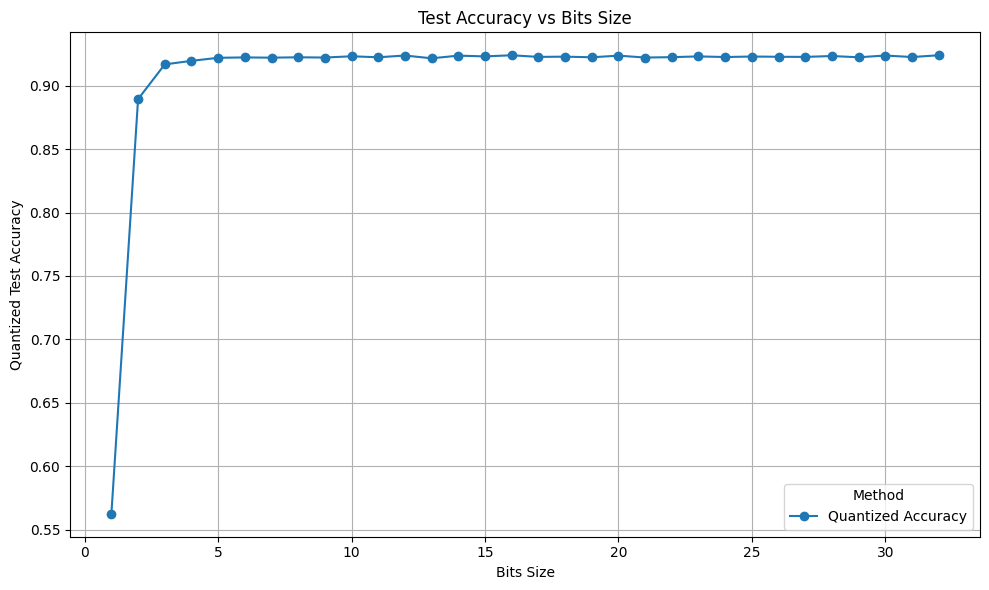

In [13]:
# Load the CSV files
quant_teacher = pd.read_csv("checkpoints_teacher/results_teacher_quantization.csv")

# Add a row with original accuracy to both dataframes
#new_row_quant = pd.DataFrame({"Bits": [32], "Quantized Test Accuracy": [0.9225]})
#quant_teacher = pd.concat([quant_teacher, new_row_quant], ignore_index=True)

# Plot both lines sharing the same axes
plt.figure(figsize=(10, 6))
plt.plot(quant_teacher["Bits"], quant_teacher["Quantized Test Accuracy"], marker='o', label="Quantized Accuracy")

# Add labels and title
plt.title("Test Accuracy vs Bits Size")
plt.xlabel("Bits Size")
plt.ylabel("Quantized Test Accuracy")
plt.grid(True)
plt.legend(title="Method", loc="best")

# Show the plot
plt.tight_layout()

# Save the plot
plt.savefig('images/teacher_quant_acc.png')

# Show the plot
plt.show()

## Student Network

#### Without KD 

In [73]:
num_epochs = 20
print_every = 100
# Hypothetical setup, please adjust according to actual import paths and methods
temperatures = [4]
alphas = [0.0] # only use label for training
learning_rates = [1e-3]
learning_rate_decays = [0.95]
weight_decays = [0.0]
momentums = [0.9]
dropout_probabilities = [(0.0, 0.0)]
hparams_list = []


for hparam_tuple in itertools.product(alphas, temperatures, dropout_probabilities, weight_decays, learning_rate_decays, momentums, learning_rates):
    hparam = {}
    hparam['alpha'] = hparam_tuple[0]
    hparam['T'] = hparam_tuple[1]
    hparam['dropout_input'] = hparam_tuple[2][0]
    hparam['dropout_hidden'] = hparam_tuple[2][1]
    hparam['weight_decay'] = hparam_tuple[3]
    hparam['lr_decay'] = hparam_tuple[4]
    hparam['momentum'] = hparam_tuple[5]
    hparam['lr'] = hparam_tuple[6]
    hparams_list.append(hparam)

results_distill_nokd = {}
pruning_factor = 0

# CSV file setup
csv_file = checkpoints_path_student_nokd + "results_student.csv"
if not os.path.exists(csv_file):
    with open(csv_file, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Alpha", "Temperature", "Dropout Input", "Dropout Hidden", "Weight Decay", "LR Decay", "Momentum", "Learning Rate", "Pruning Factor", "Zero Parameters", "Test Accuracy", "Training Time (s)"])

# Training and logging
for hparam in hparams_list:
    print('Training with hparams' + utils.hparamToString(hparam) + f' and pruning factor {pruning_factor}')

    # Measure training time
    start_time = time.time()

    reproducibilitySeed()
    student_net = networks.StudentNetwork(pruning_factor, teacher_net, q=False, fuse=False, qat=False, dif_arch=True)
    student_net.to(fast_device)
    hparam_tuple = utils.hparamDictToTuple(hparam)

    # Count parameters
    student_params_num = count_parameters(student_net)
    
    print(pruning_factor, student_params_num, count_parameters(teacher_net))
    results_distill_nokd[(hparam_tuple, pruning_factor)] = utils.trainStudentOnHparam(
            teacher_net, student_net, hparam, num_epochs,
            train_loader, val_loader,
            print_every=print_every,
            fast_device=fast_device, quant=False,
            checkpoint_save_path = checkpoints_path_student_nokd
        )

    training_time = time.time() - start_time

    # Final model save
    final_save_path = checkpoints_path_student_nokd + utils.hparamToString(hparam) + '.tar'
    torch.save({
        'results': results_distill_nokd[(hparam_tuple, pruning_factor)],
        'model_state_dict': quantized_model.state_dict(),
        'epoch': num_epochs
    }, final_save_path)

    # Calculate test accuracy
    _, test_accuracy = utils.getLossAccuracyOnDataset(student_net, test_loader, fast_device)
    print('Test accuracy: ', test_accuracy)

    # Write results to CSV
    with open(csv_file, mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([
            hparam['alpha'], hparam['T'], hparam['dropout_input'], hparam['dropout_hidden'], hparam['weight_decay'],
            hparam['lr_decay'], hparam['momentum'], hparam['lr'], pruning_factor, student_params_num,
            test_accuracy, training_time
        ])

print(f"Results saved to {csv_file}")

Training with hparamsT=4, alpha=0.0, dropout_hidden=0.0, dropout_input=0.0, lr=0.001, lr_decay=0.95, momentum=0.9, weight_decay=0.0 and pruning factor 0
0 11173962 23520842
epoch: 0 validation accuracy: 0.110
[1,   100/  372] train loss: 1.450 train accuracy: 0.453
[1,   200/  372] train loss: 0.954 train accuracy: 0.703
[1,   300/  372] train loss: 0.751 train accuracy: 0.758
epoch: 1 validation accuracy: 0.742
[2,   100/  372] train loss: 0.602 train accuracy: 0.773
[2,   200/  372] train loss: 0.441 train accuracy: 0.852
[2,   300/  372] train loss: 0.438 train accuracy: 0.852
epoch: 2 validation accuracy: 0.826
[3,   100/  372] train loss: 0.491 train accuracy: 0.828
[3,   200/  372] train loss: 0.349 train accuracy: 0.883
[3,   300/  372] train loss: 0.368 train accuracy: 0.875
epoch: 3 validation accuracy: 0.862
[4,   100/  372] train loss: 0.361 train accuracy: 0.898
[4,   200/  372] train loss: 0.385 train accuracy: 0.867
[4,   300/  372] train loss: 0.267 train accuracy: 0.891

In [21]:
# Quantization CSV file setup
csv_file = "checkpoints_student/checkpoints_student_nokd/results_student_quantization.csv"
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Bits", "Effective Bits", "Original Test Accuracy", "Quantized Test Accuracy", "Sparsity", "Training Time (s)"])

In [22]:
checkpoint = torch.load('checkpoints_student/checkpoints_student_NoKD/student_epoch_19.pth')
student_net = networks.StudentNetwork(0.0, teacher_net = teacher_net)
student_net = student_net.to(fast_device)
student_net.load_state_dict(checkpoint)

utils.getLossAccuracyOnDataset(student_net, test_loader, fast_device)

csv_file = "checkpoints_student/checkpoints_student_nokd/results_student_quantization.csv"

C:\Users\17598\AppData\Local\Temp\ipykernel_14284\2355955617.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('checkpoints_student/checkpoints_stu

In [28]:
# Create two range objects
range1 = range(32, 16,-4)
range2= range(16, 8, -2)
range3= range(8, 0, -1)
bits_list = list(range1) + list(range2) + list(range3)

for bits in bits_list:
    # Quantization process
    quantizer = QuantizeNeuralNet(
        student_net.model,
        'resnet18',
        batch_size=128,
        data_loader=train_loader,
        mlp_bits=bits,
        cnn_bits=bits,
        ignore_layers=[],
        mlp_alphabet_scalar=3.5,
        cnn_alphabet_scalar=3.5,
        mlp_percentile=1,
        cnn_percentile=1,
        reg=None,
        lamb=0.1,
        retain_rate=0.25,
        stochastic_quantization=False,
        device=fast_device
    )
    
    # Measure training time
    start_time = time.time()

    quantized_model = quantizer.quantize_network(False)

    training_time = time.time() - start_time

    # Check quantized model bit size
    effective_bit_size = calculate_bit_size(quantized_model)
    print(f"Bits {bits}, Effective Quantized Bit Size: {effective_bit_size}")

    _, quantized_test_accuracy = utils.getLossAccuracyOnDataset(quantized_model, test_loader, fast_device)
    print(f"Bits {bits}, Quantized Test Accuracy: {quantized_test_accuracy}")

    sparsity = utils.eval_sparsity(quantized_model)

    parameter = count_parameters(quantized_model) 

    # Write results to CSV
    with open(csv_file, mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([
            bits,effective_bit_size, 0.8891, quantized_test_accuracy,sparsity, training_time  # Include effective bit size
        ])

print(f"Results saved to {csv_file}")

The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 253.23it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2422.05it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2139.09it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2112.42it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2172.35it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1704.79it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3005.22it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 316.26it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2640.52it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3167.43it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2429.40it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3195.55it/s]


The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 859.70it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3000.23it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3172.93it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2977.87it/s]


The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3095.73it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1139.21it/s]


The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3133.13it/s]


The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3160.62it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 2984.59it/s]


Bits 32, Effective Quantized Bit Size: 21.121295382962643
Bits 32, Quantized Test Accuracy: 0.8648
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 339.48it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 928.57it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2431.27it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2365.32it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2251.74it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1433.02it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2726.07it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 309.30it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3185.07it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3039.20it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2413.48it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2648.51it/s]


The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 816.46it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3323.56it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3250.70it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2839.58it/s]


The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 2970.47it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1474.22it/s]


The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3119.58it/s]


The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 2798.12it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 2835.13it/s]


Bits 28, Effective Quantized Bit Size: 21.121295382962643
Bits 28, Quantized Test Accuracy: 0.8839
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 295.28it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 877.34it/s] 


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2386.66it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2046.57it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2110.28it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1687.27it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2871.82it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 330.39it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2335.49it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3155.10it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2422.64it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3276.43it/s]


The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 917.68it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2605.33it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3081.94it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2697.22it/s]


The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 2834.13it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1073.28it/s]


The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 2734.81it/s]


The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 2882.14it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 3695.13it/s]


Bits 24, Effective Quantized Bit Size: 20.223940621956654
Bits 24, Quantized Test Accuracy: 0.8746
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 353.50it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1371.96it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2667.69it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2793.83it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2443.84it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1828.68it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3415.23it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 352.71it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3612.95it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3634.16it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2841.29it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3211.72it/s]


The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 1081.01it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3541.97it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3603.05it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3207.15it/s]


The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3062.22it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1356.89it/s]


The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3115.35it/s]


The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3275.76it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 3214.64it/s]


Bits 20, Effective Quantized Bit Size: 17.898076259790393
Bits 20, Quantized Test Accuracy: 0.8651
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 366.28it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 953.86it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2663.77it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2696.33it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2251.75it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1928.76it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3096.66it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 352.20it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3251.74it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3623.71it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2729.39it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3666.10it/s]


The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 983.42it/s] 


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3319.87it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3402.21it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3247.02it/s]


The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3216.46it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1581.97it/s]


The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3591.94it/s]


The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3513.91it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 3683.69it/s]


Bits 16, Effective Quantized Bit Size: 14.82808192832587
Bits 16, Quantized Test Accuracy: 0.8572
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 398.25it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1515.24it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2880.01it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2873.82it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2576.53it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1528.56it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3220.64it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 346.78it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3497.85it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3118.76it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2353.56it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3446.54it/s]


The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 907.32it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3805.05it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3649.74it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3398.35it/s]


The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3380.69it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1647.82it/s]


The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3705.84it/s]


The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3638.01it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 2915.65it/s]


Bits 14, Effective Quantized Bit Size: 13.354393007601065
Bits 14, Quantized Test Accuracy: 0.8773
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 283.15it/s]


The number of groups: 1



 27%|██▋       | 157/576 [00:00<00:01, 415.81it/s]


KeyboardInterrupt: 

### Vanilla

In [77]:
num_epochs = 20
print_every = 100

# Hypothetical setup, please adjust according to actual import paths and methods
temperatures = [4]
alphas = [1.0]
learning_rates = [1e-3]
learning_rate_decays = [0.95]
weight_decays = [0.0]
momentums = [0.9]
dropout_probabilities = [(0.0, 0.0)]
hparams_list = []


for hparam_tuple in itertools.product(alphas, temperatures, dropout_probabilities, weight_decays, learning_rate_decays, momentums, learning_rates):
    hparam = {}
    hparam['alpha'] = hparam_tuple[0]
    hparam['T'] = hparam_tuple[1]
    hparam['dropout_input'] = hparam_tuple[2][0]
    hparam['dropout_hidden'] = hparam_tuple[2][1]
    hparam['weight_decay'] = hparam_tuple[3]
    hparam['lr_decay'] = hparam_tuple[4]
    hparam['momentum'] = hparam_tuple[5]
    hparam['lr'] = hparam_tuple[6]
    hparams_list.append(hparam)

results_distill_van = {}
pruning_factor = 0

# CSV file setup
csv_file = checkpoints_path_student_van + "results_student.csv"
if not os.path.exists(csv_file):
    with open(csv_file, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Alpha", "Temperature", "Dropout Input", "Dropout Hidden", "Weight Decay", "LR Decay", "Momentum", "Learning Rate", "Pruning Factor", "Zero Parameters", "Test Accuracy", "Training Time (s)"])

# Training and logging
for hparam in hparams_list:
    print('Training with hparams' + utils.hparamToString(hparam) + f' and pruning factor {pruning_factor}')

    # Measure training time
    start_time = time.time()

    reproducibilitySeed()
    student_net = networks.StudentNetwork(pruning_factor, teacher_net, q=False, fuse=False, qat=False, dif_arch=True)
    student_net.to(fast_device)
    hparam_tuple = utils.hparamDictToTuple(hparam)

    # Count parameters
    student_params_num = count_parameters(student_net)
    
    print(pruning_factor, student_params_num, count_parameters(teacher_net))

    results_distill_van[(hparam_tuple, pruning_factor)] = utils.trainStudentOnHparam(
            teacher_net, student_net, hparam, num_epochs,
            train_loader, val_loader,
            print_every=print_every,
            fast_device=fast_device, quant=False,
            checkpoint_save_path = checkpoints_path_student_van
        )

    training_time = time.time() - start_time

    # Final model save
    final_save_path = checkpoints_path_student_van + utils.hparamToString(hparam) + '.tar'
    torch.save({
        'results': results_distill_van[(hparam_tuple, pruning_factor)],
        'model_state_dict': student_net.state_dict(),
        'epoch': num_epochs
    }, final_save_path)

    # Calculate test accuracy
    _, test_accuracy = utils.getLossAccuracyOnDataset(student_net, test_loader, fast_device)
    print('Test accuracy: ', test_accuracy)

    # Write results to CSV
    with open(csv_file, mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([
            hparam['alpha'], hparam['T'], hparam['dropout_input'], hparam['dropout_hidden'], hparam['weight_decay'],
            hparam['lr_decay'], hparam['momentum'], hparam['lr'], pruning_factor, student_params_num,
            test_accuracy, training_time
        ])

print(f"Results saved to {csv_file}")

Training with hparamsT=4, alpha=1.0, dropout_hidden=0.0, dropout_input=0.0, lr=0.001, lr_decay=0.95, momentum=0.9, weight_decay=0.0 and pruning factor 0


c:\Users\17598\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\17598\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


0 11173962 23520842
epoch: 0 validation accuracy: 0.110
[1,   100/  372] train loss: 5.777 train accuracy: 0.680
[1,   200/  372] train loss: 3.589 train accuracy: 0.797
[1,   300/  372] train loss: 2.916 train accuracy: 0.836
epoch: 1 validation accuracy: 0.858
[2,   100/  372] train loss: 1.893 train accuracy: 0.906
[2,   200/  372] train loss: 1.805 train accuracy: 0.953
[2,   300/  372] train loss: 1.338 train accuracy: 0.930
epoch: 2 validation accuracy: 0.888
[3,   100/  372] train loss: 1.538 train accuracy: 0.922
[3,   200/  372] train loss: 1.118 train accuracy: 0.930
[3,   300/  372] train loss: 1.191 train accuracy: 0.953
epoch: 3 validation accuracy: 0.901
[4,   100/  372] train loss: 1.134 train accuracy: 0.938
[4,   200/  372] train loss: 1.383 train accuracy: 0.938
[4,   300/  372] train loss: 0.837 train accuracy: 0.953
epoch: 4 validation accuracy: 0.907
[5,   100/  372] train loss: 0.899 train accuracy: 0.953
[5,   200/  372] train loss: 0.848 train accuracy: 0.977
[5

In [11]:
checkpoint = torch.load('checkpoints_student/checkpoints_student_VAN/student_epoch_19.pth')
student_net = networks.StudentNetwork(0.0, teacher_net = teacher_net)
student_net = student_net.to(fast_device)
student_net.load_state_dict(checkpoint)

utils.getLossAccuracyOnDataset(student_net, test_loader, fast_device)

C:\Users\17598\AppData\Local\Temp\ipykernel_19604\4284167774.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('checkpoints_student/checkpoints_stu

(0.0, 0.9152)

In [12]:
# Quantization CSV file setup
csv_file = "checkpoints_student/checkpoints_student_VAN/results_student_quantization_van.csv"
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Bits", "Original Test Accuracy", "Quantized Test Accuracy", "Training Time (s)"])

In [ ]:
range1 = range(32, 16,-4)
range2= range(16, 8, -2)
#range3= range(8, 0, -1)
bits_list = list(range1) + list(range2)

#bits_list = range(8, 1, -1)  # 2, 4, ..., 30

for bits in bits_list:
    # Quantization process
    quantizer = QuantizeNeuralNet(
        student_net.model,
        'resnet18',
        batch_size=128,
        data_loader=train_loader,
        mlp_bits=bits,
        cnn_bits=bits,
        ignore_layers=[],
        mlp_alphabet_scalar=1.75,
        cnn_alphabet_scalar=1.75,
        mlp_percentile=1,
        cnn_percentile=1,
        reg=None,
        lamb=0.1,
        retain_rate=0.25,
        stochastic_quantization=False,
        device=fast_device
    )
    
    # Measure training time
    start_time = time.time()

    quantized_model = quantizer.quantize_network()

    training_time = time.time() - start_time

    # Check quantized model bit size
    effective_bit_size = calculate_bit_size(quantized_model)
    print(f"Bits {bits}, Effective Quantized Bit Size: {effective_bit_size}")

    _, quantized_test_accuracy = utils.getLossAccuracyOnDataset(quantized_model, test_loader, fast_device)
    print(f"Bits {bits}, Quantized Test Accuracy: {quantized_test_accuracy}")

    parameter = count_parameters(quantized_model) 

    # Write results to CSV
    with open(csv_file, mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([
            bits, 0.9152, quantized_test_accuracy, training_time  # Include effective bit size
        ])

print(f"Results saved to {csv_file}")

Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 298.95it/s]

The quantization error of layer 0 is 0.39277034997940063.
The relative quantization error of layer 0 is 0.0010952827287837863.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1079.17it/s]


The quantization error of layer 1 is 0.6847661733627319.
The relative quantization error of layer 1 is 0.0013415715657174587.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1879.46it/s]


The quantization error of layer 2 is 0.9104528427124023.
The relative quantization error of layer 2 is 0.0035719224251806736.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1538.29it/s]


The quantization error of layer 3 is 3.4853434562683105.
The relative quantization error of layer 3 is 0.0066094789654016495.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1311.28it/s]


The quantization error of layer 4 is 1.5591304302215576.
The relative quantization error of layer 4 is 0.008467989042401314.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1298.20it/s]


The quantization error of layer 5 is 4.100386619567871.
The relative quantization error of layer 5 is 0.005885724443942308.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2703.81it/s]


The quantization error of layer 6 is 0.7553324103355408.
The relative quantization error of layer 6 is 0.004783113952726126.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 296.58it/s]


The quantization error of layer 7 is 52.4866828918457.
The relative quantization error of layer 7 is 0.06716862320899963.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3354.91it/s]


The quantization error of layer 8 is 8.71116828918457.
The relative quantization error of layer 8 is 0.03695223852992058.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2770.20it/s]


The quantization error of layer 9 is 3.419408082962036.
The relative quantization error of layer 9 is 0.03582838922739029.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2398.43it/s]


The quantization error of layer 10 is 15.97752571105957.
The relative quantization error of layer 10 is 0.042942363768815994.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2647.38it/s]


The quantization error of layer 11 is 2.8548429012298584.
The relative quantization error of layer 11 is 0.023375187069177628.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 559.40it/s]


The quantization error of layer 12 is 17.592355728149414.
The relative quantization error of layer 12 is 0.07542461901903152.


Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3289.02it/s]


The quantization error of layer 13 is 3.3358840942382812.
The relative quantization error of layer 13 is 0.01880255900323391.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2933.90it/s]


The quantization error of layer 14 is 1.5630598068237305.
The relative quantization error of layer 14 is 0.026864128187298775.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2814.53it/s]


The quantization error of layer 15 is 8.408812522888184.
The relative quantization error of layer 15 is 0.033985741436481476.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3096.38it/s]


The quantization error of layer 16 is 1.3174551725387573.
The relative quantization error of layer 16 is 0.020973924547433853.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1282.76it/s]


The quantization error of layer 17 is 18.768291473388672.
The relative quantization error of layer 17 is 0.11393416672945023.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3415.97it/s]


The quantization error of layer 18 is 5.353313446044922.
The relative quantization error of layer 18 is 0.02989848330616951.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3187.51it/s]


The quantization error of layer 19 is 3.612715482711792.
The relative quantization error of layer 19 is 0.10078819841146469.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 3208.33it/s]

The quantization error of layer 20 is 27.925209045410156.
The relative quantization error of layer 20 is 0.2060045748949051.



Bits 32, Effective Quantized Bit Size: 21.121295382962643
Bits 32, Quantized Test Accuracy: 0.896
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 324.57it/s]

The quantization error of layer 0 is 0.4000031352043152.
The relative quantization error of layer 0 is 0.0011592902010306716.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 833.58it/s]


The quantization error of layer 1 is 0.6629579067230225.
The relative quantization error of layer 1 is 0.001295373309403658.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2209.34it/s]


The quantization error of layer 2 is 0.8843774199485779.
The relative quantization error of layer 2 is 0.0034916347358375788.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2450.01it/s]


The quantization error of layer 3 is 3.4226114749908447.
The relative quantization error of layer 3 is 0.006511568557471037.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2259.41it/s]


The quantization error of layer 4 is 1.5949113368988037.
The relative quantization error of layer 4 is 0.008683440275490284.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1595.37it/s]


The quantization error of layer 5 is 4.161055564880371.
The relative quantization error of layer 5 is 0.006069284863770008.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2885.02it/s]


The quantization error of layer 6 is 0.7236481308937073.
The relative quantization error of layer 6 is 0.0045067803002893925.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 281.20it/s]


The quantization error of layer 7 is 52.76427459716797.
The relative quantization error of layer 7 is 0.06769004464149475.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2961.08it/s]


The quantization error of layer 8 is 8.772459030151367.
The relative quantization error of layer 8 is 0.037050798535346985.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3256.58it/s]


The quantization error of layer 9 is 3.3152272701263428.
The relative quantization error of layer 9 is 0.03488386049866676.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2630.83it/s]


The quantization error of layer 10 is 15.762551307678223.
The relative quantization error of layer 10 is 0.04164838790893555.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3436.04it/s]


The quantization error of layer 11 is 2.8921823501586914.
The relative quantization error of layer 11 is 0.023499667644500732.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 922.27it/s]

The quantization error of layer 12 is 16.785024642944336.
The relative quantization error of layer 12 is 0.0720708966255188.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3137.66it/s]


The quantization error of layer 13 is 3.278362274169922.
The relative quantization error of layer 13 is 0.018562309443950653.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3029.40it/s]


The quantization error of layer 14 is 1.5698457956314087.
The relative quantization error of layer 14 is 0.02636519819498062.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2990.95it/s]


The quantization error of layer 15 is 7.550659656524658.
The relative quantization error of layer 15 is 0.031405337154865265.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 2995.42it/s]


The quantization error of layer 16 is 1.1624956130981445.
The relative quantization error of layer 16 is 0.018722036853432655.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1209.30it/s]


The quantization error of layer 17 is 17.088817596435547.
The relative quantization error of layer 17 is 0.10025466978549957.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 2782.02it/s]


The quantization error of layer 18 is 5.721348285675049.
The relative quantization error of layer 18 is 0.03134088218212128.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3094.29it/s]


The quantization error of layer 19 is 3.7453715801239014.
The relative quantization error of layer 19 is 0.1052098423242569.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 3275.78it/s]

The quantization error of layer 20 is 30.17056655883789.
The relative quantization error of layer 20 is 0.21855692565441132.



Bits 28, Effective Quantized Bit Size: 21.121295382962643
Bits 28, Quantized Test Accuracy: 0.8941
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 272.71it/s]

The quantization error of layer 0 is 0.4049728810787201.
The relative quantization error of layer 0 is 0.0011258465237915516.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2743.25it/s]


The quantization error of layer 1 is 0.6282755136489868.
The relative quantization error of layer 1 is 0.0012333820341154933.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2727.77it/s]


The quantization error of layer 2 is 0.9079079627990723.
The relative quantization error of layer 2 is 0.003584959078580141.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2600.56it/s]


The quantization error of layer 3 is 3.4459609985351562.
The relative quantization error of layer 3 is 0.006548640318214893.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2305.92it/s]


The quantization error of layer 4 is 1.5345786809921265.
The relative quantization error of layer 4 is 0.008423159830272198.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1310.92it/s]


The quantization error of layer 5 is 4.128939151763916.
The relative quantization error of layer 5 is 0.005986825563013554.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2805.13it/s]


The quantization error of layer 6 is 0.7209913730621338.
The relative quantization error of layer 6 is 0.004539549350738525.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 320.02it/s]


The quantization error of layer 7 is 53.0294075012207.
The relative quantization error of layer 7 is 0.06802986562252045.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2913.23it/s]


The quantization error of layer 8 is 8.270751953125.
The relative quantization error of layer 8 is 0.034818343818187714.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3019.05it/s]


The quantization error of layer 9 is 3.499906063079834.
The relative quantization error of layer 9 is 0.03654412552714348.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2386.00it/s]


The quantization error of layer 10 is 17.760196685791016.
The relative quantization error of layer 10 is 0.04694872349500656.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3057.72it/s]


The quantization error of layer 11 is 3.5075509548187256.
The relative quantization error of layer 11 is 0.028799237683415413.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 918.03it/s]

The quantization error of layer 12 is 19.508878707885742.
The relative quantization error of layer 12 is 0.08379059284925461.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3094.38it/s]


The quantization error of layer 13 is 4.027219295501709.
The relative quantization error of layer 13 is 0.022711580619215965.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3106.34it/s]


The quantization error of layer 14 is 1.7820394039154053.
The relative quantization error of layer 14 is 0.030491875484585762.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2992.56it/s]


The quantization error of layer 15 is 8.008028984069824.
The relative quantization error of layer 15 is 0.032775912433862686.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3219.83it/s]


The quantization error of layer 16 is 1.2122421264648438.
The relative quantization error of layer 16 is 0.01925857923924923.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1544.35it/s]

The quantization error of layer 17 is 18.536157608032227.
The relative quantization error of layer 17 is 0.10969772934913635.




Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3244.13it/s]


The quantization error of layer 18 is 6.069173812866211.
The relative quantization error of layer 18 is 0.033728163689374924.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3136.84it/s]


The quantization error of layer 19 is 3.642462730407715.
The relative quantization error of layer 19 is 0.10173378884792328.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 3244.07it/s]

The quantization error of layer 20 is 27.6435604095459.
The relative quantization error of layer 20 is 0.2039441615343094.



Bits 24, Effective Quantized Bit Size: 20.329511770310297
Bits 24, Quantized Test Accuracy: 0.8954
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 193.44it/s]


The quantization error of layer 0 is 0.392339289188385.
The relative quantization error of layer 0 is 0.0010996161727234721.


Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 911.11it/s] 


The quantization error of layer 1 is 0.6635518074035645.
The relative quantization error of layer 1 is 0.0012980905594304204.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2136.25it/s]


The quantization error of layer 2 is 0.9124279618263245.
The relative quantization error of layer 2 is 0.003575272858142853.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2370.29it/s]


The quantization error of layer 3 is 3.487677574157715.
The relative quantization error of layer 3 is 0.006615561433136463.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2512.83it/s]


The quantization error of layer 4 is 1.5798944234848022.
The relative quantization error of layer 4 is 0.008567859418690205.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1894.07it/s]


The quantization error of layer 5 is 3.993544578552246.
The relative quantization error of layer 5 is 0.005785292014479637.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2248.10it/s]


The quantization error of layer 6 is 0.6868988275527954.
The relative quantization error of layer 6 is 0.004304639995098114.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 347.55it/s]


The quantization error of layer 7 is 52.23198699951172.
The relative quantization error of layer 7 is 0.06681926548480988.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3274.18it/s]


The quantization error of layer 8 is 8.494301795959473.
The relative quantization error of layer 8 is 0.036006372421979904.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3378.10it/s]


The quantization error of layer 9 is 3.413997173309326.
The relative quantization error of layer 9 is 0.03532135859131813.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2490.70it/s]


The quantization error of layer 10 is 14.675911903381348.
The relative quantization error of layer 10 is 0.038941510021686554.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2947.04it/s]


The quantization error of layer 11 is 2.6042065620422363.
The relative quantization error of layer 11 is 0.02135528065264225.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 538.03it/s]


The quantization error of layer 12 is 15.678495407104492.
The relative quantization error of layer 12 is 0.06719467788934708.


Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2543.96it/s]


The quantization error of layer 13 is 2.9687249660491943.
The relative quantization error of layer 13 is 0.01700659841299057.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2828.59it/s]


The quantization error of layer 14 is 2.212885618209839.
The relative quantization error of layer 14 is 0.036895010620355606.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 1815.17it/s]


The quantization error of layer 15 is 9.241768836975098.
The relative quantization error of layer 15 is 0.037870682775974274.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 2822.37it/s]


The quantization error of layer 16 is 1.4603126049041748.
The relative quantization error of layer 16 is 0.022777095437049866.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1450.42it/s]

The quantization error of layer 17 is 19.280590057373047.
The relative quantization error of layer 17 is 0.11703003197908401.




Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3399.88it/s]


The quantization error of layer 18 is 6.516566276550293.
The relative quantization error of layer 18 is 0.035810183733701706.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3440.46it/s]


The quantization error of layer 19 is 3.713736057281494.
The relative quantization error of layer 19 is 0.1057620570063591.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 3749.24it/s]

The quantization error of layer 20 is 30.935596466064453.
The relative quantization error of layer 20 is 0.22497349977493286.



Bits 20, Effective Quantized Bit Size: 18.51170855959596
Bits 20, Quantized Test Accuracy: 0.8894
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 312.35it/s]

The quantization error of layer 0 is 0.3889307379722595.
The relative quantization error of layer 0 is 0.0011105387238785625.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2747.76it/s]


The quantization error of layer 1 is 0.6741010546684265.
The relative quantization error of layer 1 is 0.0013194662751629949.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2844.08it/s]


The quantization error of layer 2 is 0.9263041019439697.
The relative quantization error of layer 2 is 0.0036742265801876783.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2942.29it/s]


The quantization error of layer 3 is 3.4474825859069824.
The relative quantization error of layer 3 is 0.006477120332419872.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2505.47it/s]


The quantization error of layer 4 is 1.582132339477539.
The relative quantization error of layer 4 is 0.008683906868100166.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1765.68it/s]


The quantization error of layer 5 is 3.9538931846618652.
The relative quantization error of layer 5 is 0.005731966812163591.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3190.86it/s]


The quantization error of layer 6 is 0.7302866578102112.
The relative quantization error of layer 6 is 0.004570908844470978.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 354.68it/s]


The quantization error of layer 7 is 53.032554626464844.
The relative quantization error of layer 7 is 0.06797988712787628.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3569.86it/s]


The quantization error of layer 8 is 8.26427173614502.
The relative quantization error of layer 8 is 0.034878868609666824.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3615.24it/s]


The quantization error of layer 9 is 3.2998266220092773.
The relative quantization error of layer 9 is 0.03469470888376236.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2732.25it/s]


The quantization error of layer 10 is 15.192987442016602.
The relative quantization error of layer 10 is 0.04044241085648537.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3771.50it/s]


The quantization error of layer 11 is 2.7751150131225586.
The relative quantization error of layer 11 is 0.022689208388328552.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 982.36it/s]

The quantization error of layer 12 is 15.637487411499023.
The relative quantization error of layer 12 is 0.06720547378063202.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3772.64it/s]


The quantization error of layer 13 is 3.101983070373535.
The relative quantization error of layer 13 is 0.01753832958638668.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3776.13it/s]


The quantization error of layer 14 is 1.651527762413025.
The relative quantization error of layer 14 is 0.028147317469120026.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2914.06it/s]


The quantization error of layer 15 is 7.030223846435547.
The relative quantization error of layer 15 is 0.029175447300076485.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3314.16it/s]


The quantization error of layer 16 is 0.9893975257873535.
The relative quantization error of layer 16 is 0.015994742512702942.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1475.89it/s]

The quantization error of layer 17 is 15.62143325805664.
The relative quantization error of layer 17 is 0.0935620442032814.




Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3508.59it/s]


The quantization error of layer 18 is 5.2421393394470215.
The relative quantization error of layer 18 is 0.02911926433444023.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3271.00it/s]


The quantization error of layer 19 is 3.414161205291748.
The relative quantization error of layer 19 is 0.09712359309196472.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 3779.14it/s]

The quantization error of layer 20 is 28.870939254760742.
The relative quantization error of layer 20 is 0.20798642933368683.



Bits 16, Effective Quantized Bit Size: 15.608501979870702
Bits 16, Quantized Test Accuracy: 0.8949
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 303.90it/s]

The quantization error of layer 0 is 0.38290125131607056.
The relative quantization error of layer 0 is 0.0010925177484750748.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 900.14it/s]


The quantization error of layer 1 is 0.680303692817688.
The relative quantization error of layer 1 is 0.0013328824425116181.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2119.62it/s]


The quantization error of layer 2 is 0.8784805536270142.
The relative quantization error of layer 2 is 0.0034660648088902235.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2379.81it/s]


The quantization error of layer 3 is 3.4677047729492188.
The relative quantization error of layer 3 is 0.006572079844772816.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2135.64it/s]


The quantization error of layer 4 is 1.5994383096694946.
The relative quantization error of layer 4 is 0.00875368807464838.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1645.66it/s]


The quantization error of layer 5 is 4.218446254730225.
The relative quantization error of layer 5 is 0.0061313738115131855.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3218.27it/s]


The quantization error of layer 6 is 0.7515804171562195.
The relative quantization error of layer 6 is 0.004722775425761938.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 337.51it/s]


The quantization error of layer 7 is 52.88628005981445.
The relative quantization error of layer 7 is 0.06782431900501251.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3255.84it/s]


The quantization error of layer 8 is 8.749241828918457.
The relative quantization error of layer 8 is 0.03660694137215614.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3035.73it/s]


The quantization error of layer 9 is 3.7015814781188965.
The relative quantization error of layer 9 is 0.03893482685089111.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2786.11it/s]


The quantization error of layer 10 is 15.599409103393555.
The relative quantization error of layer 10 is 0.04140862450003624.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3566.09it/s]


The quantization error of layer 11 is 3.030876636505127.
The relative quantization error of layer 11 is 0.024655215442180634.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 962.73it/s]

The quantization error of layer 12 is 16.865388870239258.
The relative quantization error of layer 12 is 0.07234807312488556.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3462.26it/s]


The quantization error of layer 13 is 3.3849823474884033.
The relative quantization error of layer 13 is 0.019382111728191376.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3556.21it/s]


The quantization error of layer 14 is 1.698472023010254.
The relative quantization error of layer 14 is 0.02824145182967186.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3121.01it/s]


The quantization error of layer 15 is 7.560546875.
The relative quantization error of layer 15 is 0.03071388229727745.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3190.50it/s]


The quantization error of layer 16 is 1.0911486148834229.
The relative quantization error of layer 16 is 0.017473755404353142.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1412.54it/s]

The quantization error of layer 17 is 16.257535934448242.
The relative quantization error of layer 17 is 0.0970480889081955.




Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3027.10it/s]


The quantization error of layer 18 is 5.2034993171691895.
The relative quantization error of layer 18 is 0.028394412249326706.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3058.20it/s]


The quantization error of layer 19 is 3.417243003845215.
The relative quantization error of layer 19 is 0.0989338755607605.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 3274.44it/s]

The quantization error of layer 20 is 26.566089630126953.
The relative quantization error of layer 20 is 0.19350853562355042.



Bits 14, Effective Quantized Bit Size: 13.78290923130041
Bits 14, Quantized Test Accuracy: 0.8991
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 237.80it/s]

The quantization error of layer 0 is 0.4051571488380432.
The relative quantization error of layer 0 is 0.0011837150668725371.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 978.35it/s]


The quantization error of layer 1 is 0.5978004932403564.
The relative quantization error of layer 1 is 0.001175524084828794.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2558.17it/s]


The quantization error of layer 2 is 0.8964295387268066.
The relative quantization error of layer 2 is 0.0035307188518345356.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2917.22it/s]


The quantization error of layer 3 is 3.4090042114257812.
The relative quantization error of layer 3 is 0.006447858642786741.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2717.60it/s]


The quantization error of layer 4 is 1.6449620723724365.
The relative quantization error of layer 4 is 0.00905210617929697.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1973.85it/s]


The quantization error of layer 5 is 4.237766742706299.
The relative quantization error of layer 5 is 0.006096412893384695.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3267.01it/s]


The quantization error of layer 6 is 0.7522769570350647.
The relative quantization error of layer 6 is 0.00467930780723691.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 320.42it/s]


The quantization error of layer 7 is 52.487735748291016.
The relative quantization error of layer 7 is 0.06738348305225372.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3020.39it/s]


The quantization error of layer 8 is 8.807205200195312.
The relative quantization error of layer 8 is 0.03687780350446701.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3225.79it/s]


The quantization error of layer 9 is 3.7579402923583984.
The relative quantization error of layer 9 is 0.03962311893701553.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2714.57it/s]


The quantization error of layer 10 is 17.0195255279541.
The relative quantization error of layer 10 is 0.04528471454977989.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3469.10it/s]


The quantization error of layer 11 is 2.927398920059204.
The relative quantization error of layer 11 is 0.0240437351167202.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 949.67it/s]

The quantization error of layer 12 is 16.787214279174805.
The relative quantization error of layer 12 is 0.07213925570249557.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3294.41it/s]


The quantization error of layer 13 is 3.435628652572632.
The relative quantization error of layer 13 is 0.01944544166326523.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3444.95it/s]


The quantization error of layer 14 is 1.6214237213134766.
The relative quantization error of layer 14 is 0.02728528156876564.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3218.16it/s]


The quantization error of layer 15 is 7.674685001373291.
The relative quantization error of layer 15 is 0.031241202726960182.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3380.03it/s]


The quantization error of layer 16 is 1.1989797353744507.
The relative quantization error of layer 16 is 0.019014211371541023.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1417.01it/s]


The quantization error of layer 17 is 17.33378028869629.
The relative quantization error of layer 17 is 0.10508865863084793.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3065.90it/s]


The quantization error of layer 18 is 5.541836738586426.
The relative quantization error of layer 18 is 0.029769746586680412.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3008.40it/s]


The quantization error of layer 19 is 3.5853235721588135.
The relative quantization error of layer 19 is 0.099579356610775.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 2678.71it/s]


The quantization error of layer 20 is 27.73855972290039.
The relative quantization error of layer 20 is 0.19995684921741486.

Bits 12, Effective Quantized Bit Size: 12.38839867184084
Bits 12, Quantized Test Accuracy: 0.8986
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 317.01it/s]


The quantization error of layer 0 is 0.5098565220832825.
The relative quantization error of layer 0 is 0.0014324208023026586.


Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1063.70it/s]


The quantization error of layer 1 is 0.824070155620575.
The relative quantization error of layer 1 is 0.0016194736817851663.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2632.63it/s]


The quantization error of layer 2 is 0.9863932728767395.
The relative quantization error of layer 2 is 0.003891106927767396.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2988.55it/s]


The quantization error of layer 3 is 3.5102713108062744.
The relative quantization error of layer 3 is 0.006693417206406593.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2754.12it/s]


The quantization error of layer 4 is 1.6834356784820557.
The relative quantization error of layer 4 is 0.009121757000684738.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1416.12it/s]


The quantization error of layer 5 is 4.4932637214660645.
The relative quantization error of layer 5 is 0.0065688020549714565.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3116.65it/s]


The quantization error of layer 6 is 0.8203321099281311.
The relative quantization error of layer 6 is 0.005147852934896946.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 338.73it/s]


The quantization error of layer 7 is 52.6271858215332.
The relative quantization error of layer 7 is 0.06759527325630188.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3146.85it/s]


The quantization error of layer 8 is 8.621349334716797.
The relative quantization error of layer 8 is 0.0365135632455349.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3507.28it/s]


The quantization error of layer 9 is 4.051296710968018.
The relative quantization error of layer 9 is 0.042403798550367355.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2780.55it/s]


The quantization error of layer 10 is 16.613649368286133.
The relative quantization error of layer 10 is 0.0439886711537838.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3344.90it/s]


The quantization error of layer 11 is 3.0313398838043213.
The relative quantization error of layer 11 is 0.02503708004951477.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 985.32it/s]

The quantization error of layer 12 is 17.0098934173584.
The relative quantization error of layer 12 is 0.0731637254357338.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3530.92it/s]


The quantization error of layer 13 is 3.4387598037719727.
The relative quantization error of layer 13 is 0.019759587943553925.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3408.95it/s]


The quantization error of layer 14 is 1.7076126337051392.
The relative quantization error of layer 14 is 0.02887733094394207.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3198.96it/s]


The quantization error of layer 15 is 7.544497013092041.
The relative quantization error of layer 15 is 0.03133143112063408.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3170.15it/s]


The quantization error of layer 16 is 1.1085125207901.
The relative quantization error of layer 16 is 0.017545994371175766.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1429.06it/s]


The quantization error of layer 17 is 16.056859970092773.
The relative quantization error of layer 17 is 0.0978785902261734.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3734.11it/s]


The quantization error of layer 18 is 5.459388732910156.
The relative quantization error of layer 18 is 0.03006809949874878.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3092.53it/s]


The quantization error of layer 19 is 3.5825047492980957.
The relative quantization error of layer 19 is 0.09781445562839508.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 3272.73it/s]

The quantization error of layer 20 is 26.281408309936523.
The relative quantization error of layer 20 is 0.19379287958145142.



Bits 10, Effective Quantized Bit Size: 10.63193234414078
Bits 10, Quantized Test Accuracy: 0.9001
Results saved to checkpoints_student/checkpoints_student_VAN/results_student_quantization_van.csv


### DML

In [116]:
 # Initialize CSV file for logging accuracies
csv_file = os.path.join(checkpoints_path_student_dml, "results_student.csv")
if not os.path.exists(csv_file):
    with open(csv_file, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Epoch', 'Student ID', 'Valid Accuracy'])

In [10]:
def trainDML(student_models, beta, num_epochs, train_loader, valid_loader, optimizers, csv_file, fast_device=torch.device('cuda:0')):
    for student in student_models:
        student.to(fast_device).train()

    criterion = nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        for data, labels in train_loader:
            data, labels = data.to(fast_device), labels.to(fast_device)

            # Zero the parameter gradients for all optimizers
            for optimizer in optimizers:
                optimizer.zero_grad()

            outputs = [student(data) for student in student_models]
            losses = []

            for i, student_output in enumerate(outputs):
                loss = criterion(student_output, labels)
                dml_loss = sum(F.mse_loss(F.softmax(student_output, dim=1), F.softmax(other_output, dim=1))
                               for j, other_output in enumerate(outputs) if i != j)
                total_loss = loss + beta * (dml_loss / (len(student_models) - 1))
                losses.append(total_loss)

            for i, loss in enumerate(losses):
                loss.backward(retain_graph=True if i < len(student_models) - 1 else False)

            for optimizer in optimizers:
                optimizer.step()

        # Evaluate and log the test accuracy after each epoch
        with open(csv_file, mode='a', newline='') as file:
            writer = csv.writer(file)
            for idx, student in enumerate(student_models):
                _, test_accuracy = utils.getLossAccuracyOnDataset(student, valid_loader, fast_device)
                writer.writerow([epoch, idx, test_accuracy])
                print(f'Student {idx} test accuracy at epoch {epoch}: {test_accuracy}')
                
                # Save checkpoints
                torch.save(student.state_dict(), f"{checkpoints_path_student_dml}student_{idx}_epoch_{epoch}.pth")
                print(f"Checkpoint saved for Student {idx} at Epoch {epoch + 1}: {checkpoints_path_student_dml}student_{idx}_epoch_{epoch}.pth")

    print("Training completed.")

In [119]:
checkpoint = torch.load('checkpoints_student/checkpoints_student_NoKD/student_epoch_19.pth')
student_net = networks.StudentNetwork(0.0, teacher_net = teacher_net)
student_net = student_net.to(fast_device)
student_net.load_state_dict(checkpoint)

utils.getLossAccuracyOnDataset(student_net, test_loader, fast_device)

C:\Users\17598\AppData\Local\Temp\ipykernel_19032\3866286448.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('checkpoints_student/checkpoints_stu

(0.0, 0.8891)

In [120]:
# Create multiple student models and their optimizers
student_models = [student_net,  networks.StudentNetwork(pruning_factor=0.0, teacher_net = teacher_net, q=True, fuse=True, qat=True, dif_arch=True)]  # Create multiple instances for DML
optimizers = [torch.optim.SGD(student.parameters(), lr=1e-3, momentum=0.9, weight_decay=0.0) for student in student_models]

trainDML(student_models, 3, 20, train_loader, val_loader, optimizers, csv_file, fast_device)

c:\Users\17598\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Student 0 test accuracy at epoch 0: 0.8896
Checkpoint saved for Student 0 at Epoch 1: checkpoints_student/checkpoints_student_DML/student_0_epoch_0.pth
Student 1 test accuracy at epoch 0: 0.674
Checkpoint saved for Student 1 at Epoch 1: checkpoints_student/checkpoints_student_DML/student_1_epoch_0.pth
Student 0 test accuracy at epoch 1: 0.8904
Checkpoint saved for Student 0 at Epoch 2: checkpoints_student/checkpoints_student_DML/student_0_epoch_1.pth
Student 1 test accuracy at epoch 1: 0.7796
Checkpoint saved for Student 1 at Epoch 2: checkpoints_student/checkpoints_student_DML/student_1_epoch_1.pth
Student 0 test accuracy at epoch 2: 0.896
Checkpoint saved for Student 0 at Epoch 3: checkpoints_student/checkpoints_student_DML/student_0_epoch_2.pth
Student 1 test accuracy at epoch 2: 0.8128
Checkpoint saved for Student 1 at Epoch 3: checkpoints_student/checkpoints_student_DML/student_1_epoch_2.pth
Student 0 test accuracy at epoch 3: 0.8988
Checkpoint saved for Student 0 at Epoch 4: chec

KeyboardInterrupt: 

In [20]:
checkpoint = torch.load('checkpoints_student/checkpoints_student_DML/student_0_epoch_5.pth')
student_net_0 = networks.StudentNetwork(0.0, teacher_net = teacher_net)
student_net_0 = student_net_0.to(fast_device)
student_net_0.load_state_dict(checkpoint)

utils.getLossAccuracyOnDataset(student_net_0, test_loader, fast_device)

C:\Users\17598\AppData\Local\Temp\ipykernel_9552\2877924804.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('checkpoints_student/checkpoints_stud

(0.0, 0.932)

In [19]:
checkpoint = torch.load('checkpoints_student/checkpoints_student_DML/student_1_epoch_5.pth')
student_net_1 = networks.StudentNetwork(pruning_factor=0.0, teacher_net = teacher_net, q=True, fuse=True, qat=True, dif_arch=True)
student_net_1 = student_net_1.to(fast_device)
student_net_1.load_state_dict(checkpoint)

utils.getLossAccuracyOnDataset(student_net_1, test_loader, fast_device)

C:\Users\17598\AppData\Local\Temp\ipykernel_9552\1917126078.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('checkpoints_student/checkpoints_stud

(0.0, 0.9179)

In [16]:
csv_file = os.path.join(checkpoints_path_student_dml, "results_student.csv")
# Create multiple student models and their optimizers
student_models = [student_net_0,  student_net_1]  # Create multiple instances for DML
optimizers = [torch.optim.SGD(student.parameters(), lr=1e-3, momentum=0.9, weight_decay=0.0) for student in student_models]

trainDML(student_models, 1, 20, train_loader, val_loader, optimizers, csv_file, fast_device)

Student 0 test accuracy at epoch 0: 0.9248
Checkpoint saved for Student 0 at Epoch 1: checkpoints_student/checkpoints_student_DML/student_0_epoch_0.pth
Student 1 test accuracy at epoch 0: 0.9148
Checkpoint saved for Student 1 at Epoch 1: checkpoints_student/checkpoints_student_DML/student_1_epoch_0.pth
Student 0 test accuracy at epoch 1: 0.9304
Checkpoint saved for Student 0 at Epoch 2: checkpoints_student/checkpoints_student_DML/student_0_epoch_1.pth
Student 1 test accuracy at epoch 1: 0.9184
Checkpoint saved for Student 1 at Epoch 2: checkpoints_student/checkpoints_student_DML/student_1_epoch_1.pth
Student 0 test accuracy at epoch 2: 0.9312
Checkpoint saved for Student 0 at Epoch 3: checkpoints_student/checkpoints_student_DML/student_0_epoch_2.pth
Student 1 test accuracy at epoch 2: 0.918
Checkpoint saved for Student 1 at Epoch 3: checkpoints_student/checkpoints_student_DML/student_1_epoch_2.pth
Student 0 test accuracy at epoch 3: 0.9292
Checkpoint saved for Student 0 at Epoch 4: che

KeyboardInterrupt: 

In [21]:
#check accuracy
checkpoint = torch.load('checkpoints_student/checkpoints_student_DML/student_0_epoch_5.pth')
student_net = networks.StudentNetwork(0.0, teacher_net = teacher_net)
student_net = student_net.to(fast_device)
student_net.load_state_dict(checkpoint)

utils.getLossAccuracyOnDataset(student_net, test_loader, fast_device)

C:\Users\17598\AppData\Local\Temp\ipykernel_9552\118716468.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('checkpoints_student/checkpoints_stude

(0.0, 0.932)

In [24]:
# Quantization CSV file setup
csv_file = "checkpoints_student/checkpoints_student_DML/results_student_quantization_dml.csv"
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Bits", "Original Test Accuracy", "Quantized Test Accuracy", "Training Time (s)"])

In [25]:
range1 = range(32, 16,-4) #3
range2= range(16, 8, -2) #1.75
range3= range(8, 1, -1) # 1.5
bits_list = list(range1) + list(range2) + list(range3)

#bits_list = range(16, 8, -2)  # 2, 4, ..., 30

for bits in bits_list:
    # Quantization process
    quantizer = QuantizeNeuralNet(
        student_net.model,
        'resnet18',
        batch_size=128,
        data_loader=train_loader,
        mlp_bits=bits,
        cnn_bits=bits,
        ignore_layers=[],
        mlp_alphabet_scalar=1.75,#3
        cnn_alphabet_scalar=1.75,
        mlp_percentile=1,
        cnn_percentile=1,
        reg=None,
        lamb=0.1,
        retain_rate=0.25,
        stochastic_quantization=False,
        device=fast_device
    )
    
    # Measure training time
    start_time = time.time()

    quantized_model = quantizer.quantize_network()

    training_time = time.time() - start_time

    # Check quantized model bit size
    effective_bit_size = calculate_bit_size(quantized_model)
    print(f"Bits {bits}, Effective Quantized Bit Size: {effective_bit_size}")

    _, quantized_test_accuracy = utils.getLossAccuracyOnDataset(quantized_model, test_loader, fast_device)
    print(f"Bits {bits}, Quantized Test Accuracy: {quantized_test_accuracy}")

    parameter = count_parameters(quantized_model) 

    # Write results to CSV
    with open(csv_file, mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([
            bits, 0.932, quantized_test_accuracy, training_time  # Include effective bit size
        ])

print(f"Results saved to {csv_file}")

Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 484.77it/s]

The quantization error of layer 0 is 1.6034061908721924.
The relative quantization error of layer 0 is 0.0045419191010296345.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1281.39it/s]


The quantization error of layer 1 is 0.8210690021514893.
The relative quantization error of layer 1 is 0.0014247754588723183.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2870.89it/s]


The quantization error of layer 2 is 1.3954623937606812.
The relative quantization error of layer 2 is 0.004846667405217886.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 3222.61it/s]


The quantization error of layer 3 is 3.846637010574341.
The relative quantization error of layer 3 is 0.0068416595458984375.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 3191.90it/s]


The quantization error of layer 4 is 1.8858684301376343.
The relative quantization error of layer 4 is 0.009037747047841549.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1903.64it/s]


The quantization error of layer 5 is 4.563040733337402.
The relative quantization error of layer 5 is 0.005488882306963205.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3290.27it/s]


The quantization error of layer 6 is 0.7388676404953003.
The relative quantization error of layer 6 is 0.004461368080228567.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 372.24it/s]


The quantization error of layer 7 is 50.64080047607422.
The relative quantization error of layer 7 is 0.0588085800409317.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3811.13it/s]


The quantization error of layer 8 is 6.421385288238525.
The relative quantization error of layer 8 is 0.023100174963474274.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3470.46it/s]


The quantization error of layer 9 is 4.2794189453125.
The relative quantization error of layer 9 is 0.04265589267015457.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2882.51it/s]


The quantization error of layer 10 is 13.535752296447754.
The relative quantization error of layer 10 is 0.03279775753617287.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3919.66it/s]


The quantization error of layer 11 is 2.7013015747070312.
The relative quantization error of layer 11 is 0.021705299615859985.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 1040.62it/s]

The quantization error of layer 12 is 13.926469802856445.
The relative quantization error of layer 12 is 0.05490966513752937.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3747.04it/s]


The quantization error of layer 13 is 3.0017311573028564.
The relative quantization error of layer 13 is 0.014291826635599136.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3427.81it/s]


The quantization error of layer 14 is 1.1321499347686768.
The relative quantization error of layer 14 is 0.017911408096551895.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3355.16it/s]


The quantization error of layer 15 is 5.480370044708252.
The relative quantization error of layer 15 is 0.02187543734908104.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3479.59it/s]


The quantization error of layer 16 is 0.7204560041427612.
The relative quantization error of layer 16 is 0.011611226946115494.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1636.85it/s]

The quantization error of layer 17 is 12.30843448638916.
The relative quantization error of layer 17 is 0.07590353488922119.




Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3664.77it/s]


The quantization error of layer 18 is 3.2783048152923584.
The relative quantization error of layer 18 is 0.01873590052127838.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3615.90it/s]


The quantization error of layer 19 is 3.071310043334961.
The relative quantization error of layer 19 is 0.08320550620555878.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 3763.88it/s]

The quantization error of layer 20 is 28.661409378051758.
The relative quantization error of layer 20 is 0.11628282070159912.



Bits 32, Effective Quantized Bit Size: 21.121295382962643
Bits 32, Quantized Test Accuracy: 0.9262
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 606.56it/s]

The quantization error of layer 0 is 1.6340504884719849.
The relative quantization error of layer 0 is 0.004353413358330727.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 3019.31it/s]


The quantization error of layer 1 is 0.8218235373497009.
The relative quantization error of layer 1 is 0.0014223679900169373.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2863.20it/s]


The quantization error of layer 2 is 1.3735090494155884.
The relative quantization error of layer 2 is 0.004828535486012697.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2894.39it/s]


The quantization error of layer 3 is 3.9283876419067383.
The relative quantization error of layer 3 is 0.006972400471568108.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 3041.59it/s]


The quantization error of layer 4 is 1.9800753593444824.
The relative quantization error of layer 4 is 0.009555031545460224.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2163.36it/s]


The quantization error of layer 5 is 4.76446533203125.
The relative quantization error of layer 5 is 0.005757438950240612.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3806.42it/s]


The quantization error of layer 6 is 0.7639604806900024.
The relative quantization error of layer 6 is 0.004679520148783922.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 357.14it/s]


The quantization error of layer 7 is 51.130279541015625.
The relative quantization error of layer 7 is 0.058942947536706924.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3519.43it/s]


The quantization error of layer 8 is 6.388765811920166.
The relative quantization error of layer 8 is 0.02300705760717392.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3911.44it/s]


The quantization error of layer 9 is 2.4042162895202637.
The relative quantization error of layer 9 is 0.023929672315716743.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2882.73it/s]


The quantization error of layer 10 is 10.567188262939453.
The relative quantization error of layer 10 is 0.025794172659516335.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3752.33it/s]


The quantization error of layer 11 is 1.6367356777191162.
The relative quantization error of layer 11 is 0.013330813497304916.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 1052.47it/s]

The quantization error of layer 12 is 11.170392036437988.
The relative quantization error of layer 12 is 0.04420310631394386.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3459.84it/s]


The quantization error of layer 13 is 1.963958501815796.
The relative quantization error of layer 13 is 0.009540165774524212.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3423.62it/s]


The quantization error of layer 14 is 0.8099636435508728.
The relative quantization error of layer 14 is 0.012994624674320221.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3389.76it/s]


The quantization error of layer 15 is 3.2622947692871094.
The relative quantization error of layer 15 is 0.013031673617661.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3585.11it/s]


The quantization error of layer 16 is 0.4953034818172455.
The relative quantization error of layer 16 is 0.007976233959197998.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1509.30it/s]

The quantization error of layer 17 is 8.150958061218262.
The relative quantization error of layer 17 is 0.050387151539325714.




Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3588.47it/s]


The quantization error of layer 18 is 2.3166699409484863.
The relative quantization error of layer 18 is 0.0129590705037117.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3775.35it/s]


The quantization error of layer 19 is 2.5999953746795654.
The relative quantization error of layer 19 is 0.07001357525587082.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 4088.12it/s]

The quantization error of layer 20 is 26.229969024658203.
The relative quantization error of layer 20 is 0.10469396412372589.



Bits 28, Effective Quantized Bit Size: 21.121295382962643
Bits 28, Quantized Test Accuracy: 0.9274
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 588.23it/s]

The quantization error of layer 0 is 1.7340162992477417.
The relative quantization error of layer 0 is 0.0044485535472631454.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 3051.18it/s]


The quantization error of layer 1 is 0.8042172789573669.
The relative quantization error of layer 1 is 0.0013930158456787467.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2990.11it/s]


The quantization error of layer 2 is 1.4495197534561157.
The relative quantization error of layer 2 is 0.005045759491622448.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 3198.16it/s]


The quantization error of layer 3 is 4.021859169006348.
The relative quantization error of layer 3 is 0.007108698599040508.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2545.98it/s]


The quantization error of layer 4 is 2.0234525203704834.
The relative quantization error of layer 4 is 0.00971995946019888.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1991.19it/s]


The quantization error of layer 5 is 4.699228763580322.
The relative quantization error of layer 5 is 0.005717112682759762.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3347.97it/s]


The quantization error of layer 6 is 0.7234443426132202.
The relative quantization error of layer 6 is 0.004414059221744537.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 348.40it/s]


The quantization error of layer 7 is 50.76596450805664.
The relative quantization error of layer 7 is 0.05898211523890495.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3401.76it/s]


The quantization error of layer 8 is 6.207004070281982.
The relative quantization error of layer 8 is 0.02258523926138878.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3572.53it/s]


The quantization error of layer 9 is 2.6301801204681396.
The relative quantization error of layer 9 is 0.026280535385012627.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2845.10it/s]


The quantization error of layer 10 is 10.515880584716797.
The relative quantization error of layer 10 is 0.025579441338777542.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3739.94it/s]


The quantization error of layer 11 is 1.6858351230621338.
The relative quantization error of layer 11 is 0.01349359005689621.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 873.40it/s]

The quantization error of layer 12 is 11.595479965209961.
The relative quantization error of layer 12 is 0.04559885710477829.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3590.68it/s]


The quantization error of layer 13 is 2.071605682373047.
The relative quantization error of layer 13 is 0.010037589818239212.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3516.33it/s]


The quantization error of layer 14 is 0.8352420330047607.
The relative quantization error of layer 14 is 0.013309190981090069.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3063.32it/s]


The quantization error of layer 15 is 3.501116991043091.
The relative quantization error of layer 15 is 0.01399252563714981.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3523.92it/s]


The quantization error of layer 16 is 0.4970720112323761.
The relative quantization error of layer 16 is 0.008065243251621723.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1541.57it/s]

The quantization error of layer 17 is 8.604816436767578.
The relative quantization error of layer 17 is 0.05311097204685211.




Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3482.74it/s]


The quantization error of layer 18 is 2.632606029510498.
The relative quantization error of layer 18 is 0.014732818119227886.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3453.94it/s]


The quantization error of layer 19 is 2.563018560409546.
The relative quantization error of layer 19 is 0.06900554895401001.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 3350.74it/s]

The quantization error of layer 20 is 24.59783363342285.
The relative quantization error of layer 20 is 0.10015450417995453.



Bits 24, Effective Quantized Bit Size: 20.329511770310297
Bits 24, Quantized Test Accuracy: 0.927
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 585.68it/s]


The quantization error of layer 0 is 1.7106568813323975.
The relative quantization error of layer 0 is 0.0045386916026473045.


Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 3041.11it/s]


The quantization error of layer 1 is 0.8246625065803528.
The relative quantization error of layer 1 is 0.0014337704051285982.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2887.61it/s]


The quantization error of layer 2 is 1.4133524894714355.
The relative quantization error of layer 2 is 0.0049454038962721825.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2927.31it/s]


The quantization error of layer 3 is 3.922698736190796.
The relative quantization error of layer 3 is 0.006939840503036976.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2890.71it/s]


The quantization error of layer 4 is 1.907779574394226.
The relative quantization error of layer 4 is 0.009164058603346348.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1953.55it/s]


The quantization error of layer 5 is 4.754419803619385.
The relative quantization error of layer 5 is 0.0057754297740757465.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3311.08it/s]


The quantization error of layer 6 is 0.7316787242889404.
The relative quantization error of layer 6 is 0.004422767087817192.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 349.53it/s]


The quantization error of layer 7 is 50.89564514160156.
The relative quantization error of layer 7 is 0.05877762660384178.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3598.06it/s]


The quantization error of layer 8 is 6.299600601196289.
The relative quantization error of layer 8 is 0.023069342598319054.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3775.04it/s]


The quantization error of layer 9 is 2.285351276397705.
The relative quantization error of layer 9 is 0.023242633789777756.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2901.92it/s]


The quantization error of layer 10 is 9.923620223999023.
The relative quantization error of layer 10 is 0.024289386346936226.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3831.03it/s]


The quantization error of layer 11 is 1.5333130359649658.
The relative quantization error of layer 11 is 0.012117435224354267.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 924.33it/s]

The quantization error of layer 12 is 11.106027603149414.
The relative quantization error of layer 12 is 0.04361741617321968.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3253.50it/s]


The quantization error of layer 13 is 1.9312599897384644.
The relative quantization error of layer 13 is 0.009387355297803879.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3605.10it/s]


The quantization error of layer 14 is 0.7765864133834839.
The relative quantization error of layer 14 is 0.012752972543239594.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3062.07it/s]


The quantization error of layer 15 is 3.7921791076660156.
The relative quantization error of layer 15 is 0.01507907547056675.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3534.92it/s]


The quantization error of layer 16 is 0.529744029045105.
The relative quantization error of layer 16 is 0.008511519990861416.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1554.95it/s]

The quantization error of layer 17 is 8.955495834350586.
The relative quantization error of layer 17 is 0.05543426424264908.




Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3433.74it/s]


The quantization error of layer 18 is 2.9461560249328613.
The relative quantization error of layer 18 is 0.01644645258784294.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3481.07it/s]


The quantization error of layer 19 is 2.845597982406616.
The relative quantization error of layer 19 is 0.07638934999704361.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 4066.45it/s]

The quantization error of layer 20 is 27.2165470123291.
The relative quantization error of layer 20 is 0.1111910417675972.



Bits 20, Effective Quantized Bit Size: 18.51500765798201
Bits 20, Quantized Test Accuracy: 0.9283
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 506.48it/s]

The quantization error of layer 0 is 1.6809929609298706.
The relative quantization error of layer 0 is 0.004408107604831457.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2742.15it/s]


The quantization error of layer 1 is 0.8521326780319214.
The relative quantization error of layer 1 is 0.0014772173017263412.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 3090.04it/s]


The quantization error of layer 2 is 1.454976201057434.
The relative quantization error of layer 2 is 0.0050542354583740234.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2921.23it/s]


The quantization error of layer 3 is 3.968796968460083.
The relative quantization error of layer 3 is 0.007078538183122873.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2927.03it/s]


The quantization error of layer 4 is 1.9632731676101685.
The relative quantization error of layer 4 is 0.009424618445336819.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1952.37it/s]


The quantization error of layer 5 is 4.889195919036865.
The relative quantization error of layer 5 is 0.00588158518075943.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3612.16it/s]


The quantization error of layer 6 is 0.7738193869590759.
The relative quantization error of layer 6 is 0.004668072797358036.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 363.66it/s]


The quantization error of layer 7 is 51.16886520385742.
The relative quantization error of layer 7 is 0.05909561365842819.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3566.83it/s]


The quantization error of layer 8 is 6.421043395996094.
The relative quantization error of layer 8 is 0.023079903796315193.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3563.14it/s]


The quantization error of layer 9 is 2.351516008377075.
The relative quantization error of layer 9 is 0.02365340106189251.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2722.62it/s]


The quantization error of layer 10 is 10.046880722045898.
The relative quantization error of layer 10 is 0.024387286975979805.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3882.07it/s]


The quantization error of layer 11 is 1.5227411985397339.
The relative quantization error of layer 11 is 0.0122766038402915.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 1008.47it/s]

The quantization error of layer 12 is 11.070531845092773.
The relative quantization error of layer 12 is 0.04359787330031395.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3469.38it/s]


The quantization error of layer 13 is 1.906536340713501.
The relative quantization error of layer 13 is 0.009270627982914448.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3326.63it/s]


The quantization error of layer 14 is 0.8283199071884155.
The relative quantization error of layer 14 is 0.013631845824420452.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2978.18it/s]


The quantization error of layer 15 is 3.3661422729492188.
The relative quantization error of layer 15 is 0.013362032361328602.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3504.82it/s]


The quantization error of layer 16 is 0.485655814409256.
The relative quantization error of layer 16 is 0.007732626982033253.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1566.43it/s]

The quantization error of layer 17 is 8.27792739868164.
The relative quantization error of layer 17 is 0.05073855444788933.




Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3557.53it/s]


The quantization error of layer 18 is 2.4752166271209717.
The relative quantization error of layer 18 is 0.013971545733511448.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3849.51it/s]


The quantization error of layer 19 is 2.4027316570281982.
The relative quantization error of layer 19 is 0.06541452556848526.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 3872.22it/s]

The quantization error of layer 20 is 22.401042938232422.
The relative quantization error of layer 20 is 0.09050998091697693.



Bits 16, Effective Quantized Bit Size: 15.397359683163412
Bits 16, Quantized Test Accuracy: 0.9286
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 601.74it/s]

The quantization error of layer 0 is 1.6195043325424194.
The relative quantization error of layer 0 is 0.004440058954060078.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1248.69it/s]


The quantization error of layer 1 is 0.8281513452529907.
The relative quantization error of layer 1 is 0.0014299977337941527.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 3112.71it/s]


The quantization error of layer 2 is 1.3907955884933472.
The relative quantization error of layer 2 is 0.004871726501733065.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 3034.20it/s]


The quantization error of layer 3 is 3.7876672744750977.
The relative quantization error of layer 3 is 0.0067142099142074585.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 3077.27it/s]


The quantization error of layer 4 is 1.9748040437698364.
The relative quantization error of layer 4 is 0.00946711003780365.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1902.23it/s]


The quantization error of layer 5 is 4.723227024078369.
The relative quantization error of layer 5 is 0.005737842991948128.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3390.82it/s]


The quantization error of layer 6 is 0.744317889213562.
The relative quantization error of layer 6 is 0.004556095693260431.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 346.18it/s]


The quantization error of layer 7 is 51.015262603759766.
The relative quantization error of layer 7 is 0.05887339636683464.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3524.57it/s]


The quantization error of layer 8 is 6.387791156768799.
The relative quantization error of layer 8 is 0.02327081188559532.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3772.49it/s]


The quantization error of layer 9 is 5.170793533325195.
The relative quantization error of layer 9 is 0.05192936584353447.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2660.68it/s]


The quantization error of layer 10 is 16.18370246887207.
The relative quantization error of layer 10 is 0.0395694300532341.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3938.74it/s]


The quantization error of layer 11 is 3.1324121952056885.
The relative quantization error of layer 11 is 0.02520320750772953.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 1008.80it/s]

The quantization error of layer 12 is 17.239011764526367.
The relative quantization error of layer 12 is 0.06807507574558258.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3682.70it/s]


The quantization error of layer 13 is 3.970907688140869.
The relative quantization error of layer 13 is 0.019125347957015038.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3717.58it/s]


The quantization error of layer 14 is 1.4678609371185303.
The relative quantization error of layer 14 is 0.023606637492775917.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3336.19it/s]


The quantization error of layer 15 is 6.131222248077393.
The relative quantization error of layer 15 is 0.024702567607164383.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3502.26it/s]


The quantization error of layer 16 is 0.8910877108573914.
The relative quantization error of layer 16 is 0.014395329169929028.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1387.55it/s]


The quantization error of layer 17 is 13.2149658203125.
The relative quantization error of layer 17 is 0.08109704405069351.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3690.29it/s]


The quantization error of layer 18 is 3.456855535507202.
The relative quantization error of layer 18 is 0.019506361335515976.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3639.87it/s]


The quantization error of layer 19 is 3.1505184173583984.
The relative quantization error of layer 19 is 0.08435948938131332.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 3816.82it/s]

The quantization error of layer 20 is 30.394975662231445.
The relative quantization error of layer 20 is 0.12338703125715256.



Bits 14, Effective Quantized Bit Size: 13.78290923130041
Bits 14, Quantized Test Accuracy: 0.9239
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 537.83it/s]

The quantization error of layer 0 is 1.702420949935913.
The relative quantization error of layer 0 is 0.004403823520988226.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2936.97it/s]


The quantization error of layer 1 is 0.8164501786231995.
The relative quantization error of layer 1 is 0.0014194168616086245.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2968.12it/s]


The quantization error of layer 2 is 1.3964576721191406.
The relative quantization error of layer 2 is 0.00492335157468915.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2855.37it/s]


The quantization error of layer 3 is 3.926543712615967.
The relative quantization error of layer 3 is 0.00694702984765172.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2747.94it/s]


The quantization error of layer 4 is 1.949960470199585.
The relative quantization error of layer 4 is 0.00938012357801199.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1942.64it/s]


The quantization error of layer 5 is 4.714146614074707.
The relative quantization error of layer 5 is 0.005748427007347345.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3635.08it/s]


The quantization error of layer 6 is 0.8553764820098877.
The relative quantization error of layer 6 is 0.005236857105046511.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 360.47it/s]


The quantization error of layer 7 is 50.831687927246094.
The relative quantization error of layer 7 is 0.05907224118709564.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3436.30it/s]


The quantization error of layer 8 is 6.392526626586914.
The relative quantization error of layer 8 is 0.023196998983621597.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3503.98it/s]


The quantization error of layer 9 is 3.4413304328918457.
The relative quantization error of layer 9 is 0.034916508942842484.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2697.88it/s]


The quantization error of layer 10 is 12.04245662689209.
The relative quantization error of layer 10 is 0.0291012953966856.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3730.77it/s]


The quantization error of layer 11 is 2.148967742919922.
The relative quantization error of layer 11 is 0.017204847186803818.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 1069.00it/s]

The quantization error of layer 12 is 12.843670845031738.
The relative quantization error of layer 12 is 0.05065331235527992.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3844.88it/s]


The quantization error of layer 13 is 2.5307626724243164.
The relative quantization error of layer 13 is 0.012096513994038105.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3871.09it/s]


The quantization error of layer 14 is 1.1316845417022705.
The relative quantization error of layer 14 is 0.018329327926039696.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3366.33it/s]


The quantization error of layer 15 is 4.308426380157471.
The relative quantization error of layer 15 is 0.017521819099783897.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3517.34it/s]


The quantization error of layer 16 is 0.6172685623168945.
The relative quantization error of layer 16 is 0.010108833201229572.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1610.36it/s]

The quantization error of layer 17 is 9.83137321472168.
The relative quantization error of layer 17 is 0.061002638190984726.




Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3384.31it/s]


The quantization error of layer 18 is 2.9199419021606445.
The relative quantization error of layer 18 is 0.016281744465231895.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3599.91it/s]


The quantization error of layer 19 is 2.796703577041626.
The relative quantization error of layer 19 is 0.07741658389568329.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 3313.27it/s]

The quantization error of layer 20 is 26.56175422668457.
The relative quantization error of layer 20 is 0.10664354264736176.



Bits 12, Effective Quantized Bit Size: 11.975644807097071
Bits 12, Quantized Test Accuracy: 0.9272
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 798.13it/s]


The quantization error of layer 0 is 1.7134493589401245.
The relative quantization error of layer 0 is 0.004606668371707201.


Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1193.51it/s]


The quantization error of layer 1 is 0.9350190162658691.
The relative quantization error of layer 1 is 0.0016278289258480072.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 3124.20it/s]


The quantization error of layer 2 is 1.4501473903656006.
The relative quantization error of layer 2 is 0.005083317868411541.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2910.22it/s]


The quantization error of layer 3 is 3.848473310470581.
The relative quantization error of layer 3 is 0.006849406287074089.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2808.02it/s]


The quantization error of layer 4 is 2.043848991394043.
The relative quantization error of layer 4 is 0.00983443297445774.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1900.83it/s]


The quantization error of layer 5 is 5.1926374435424805.
The relative quantization error of layer 5 is 0.006324139889329672.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3371.56it/s]


The quantization error of layer 6 is 0.8489477038383484.
The relative quantization error of layer 6 is 0.005095102358609438.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 342.97it/s]


The quantization error of layer 7 is 51.171241760253906.
The relative quantization error of layer 7 is 0.059473443776369095.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3691.00it/s]


The quantization error of layer 8 is 6.187424182891846.
The relative quantization error of layer 8 is 0.022560536861419678.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3695.59it/s]


The quantization error of layer 9 is 2.239987373352051.
The relative quantization error of layer 9 is 0.022915195673704147.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2851.55it/s]


The quantization error of layer 10 is 10.377409934997559.
The relative quantization error of layer 10 is 0.02495371550321579.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3990.57it/s]


The quantization error of layer 11 is 1.5325698852539062.
The relative quantization error of layer 11 is 0.012203331105411053.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 1120.56it/s]

The quantization error of layer 12 is 10.922422409057617.
The relative quantization error of layer 12 is 0.043143630027770996.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3921.49it/s]


The quantization error of layer 13 is 1.9315263032913208.
The relative quantization error of layer 13 is 0.009248443879187107.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3701.86it/s]


The quantization error of layer 14 is 0.8593131303787231.
The relative quantization error of layer 14 is 0.013947177678346634.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3161.83it/s]


The quantization error of layer 15 is 4.245078086853027.
The relative quantization error of layer 15 is 0.017383676022291183.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3450.69it/s]


The quantization error of layer 16 is 0.6025295257568359.
The relative quantization error of layer 16 is 0.009997772984206676.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1570.27it/s]

The quantization error of layer 17 is 9.69861888885498.
The relative quantization error of layer 17 is 0.0599994957447052.




Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3549.28it/s]


The quantization error of layer 18 is 2.891529083251953.
The relative quantization error of layer 18 is 0.01613547094166279.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3661.16it/s]


The quantization error of layer 19 is 2.7675106525421143.
The relative quantization error of layer 19 is 0.0751563087105751.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 3864.50it/s]

The quantization error of layer 20 is 25.48686408996582.
The relative quantization error of layer 20 is 0.10376022011041641.



Bits 10, Effective Quantized Bit Size: 10.420790047433488
Bits 10, Quantized Test Accuracy: 0.927
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 620.03it/s]

The quantization error of layer 0 is 2.179626226425171.
The relative quantization error of layer 0 is 0.005619963631033897.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 3165.91it/s]


The quantization error of layer 1 is 2.0394980907440186.
The relative quantization error of layer 1 is 0.0035254850517958403.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 3166.15it/s]


The quantization error of layer 2 is 2.0753116607666016.
The relative quantization error of layer 2 is 0.007325008511543274.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 3024.98it/s]


The quantization error of layer 3 is 4.905028343200684.
The relative quantization error of layer 3 is 0.008700389415025711.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2589.31it/s]


The quantization error of layer 4 is 2.5594935417175293.
The relative quantization error of layer 4 is 0.012226278893649578.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1842.56it/s]


The quantization error of layer 5 is 7.882109642028809.
The relative quantization error of layer 5 is 0.009533841162919998.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3330.11it/s]


The quantization error of layer 6 is 1.4930896759033203.
The relative quantization error of layer 6 is 0.009185107424855232.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 343.99it/s]


The quantization error of layer 7 is 51.456485748291016.
The relative quantization error of layer 7 is 0.05969624221324921.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3831.48it/s]


The quantization error of layer 8 is 6.785183429718018.
The relative quantization error of layer 8 is 0.024652652442455292.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3707.33it/s]


The quantization error of layer 9 is 2.663144588470459.
The relative quantization error of layer 9 is 0.026695478707551956.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2885.30it/s]


The quantization error of layer 10 is 10.946427345275879.
The relative quantization error of layer 10 is 0.026405639946460724.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 4031.11it/s]


The quantization error of layer 11 is 1.8232903480529785.
The relative quantization error of layer 11 is 0.0142940329387784.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 890.42it/s]

The quantization error of layer 12 is 11.822142601013184.
The relative quantization error of layer 12 is 0.04649623855948448.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3398.53it/s]


The quantization error of layer 13 is 2.2338545322418213.
The relative quantization error of layer 13 is 0.010638386942446232.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3234.76it/s]


The quantization error of layer 14 is 0.8900365829467773.
The relative quantization error of layer 14 is 0.014747277833521366.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3250.35it/s]


The quantization error of layer 15 is 3.899848699569702.
The relative quantization error of layer 15 is 0.015942096710205078.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3507.13it/s]


The quantization error of layer 16 is 0.559806227684021.
The relative quantization error of layer 16 is 0.008907780051231384.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1457.15it/s]


The quantization error of layer 17 is 9.180231094360352.
The relative quantization error of layer 17 is 0.05691156163811684.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3663.97it/s]


The quantization error of layer 18 is 2.9187841415405273.
The relative quantization error of layer 18 is 0.016389641910791397.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3817.95it/s]


The quantization error of layer 19 is 2.5594565868377686.
The relative quantization error of layer 19 is 0.06966757774353027.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 4204.22it/s]

The quantization error of layer 20 is 25.49038314819336.
The relative quantization error of layer 20 is 0.10413079708814621.



Bits 8, Effective Quantized Bit Size: 8.633652414425608
Bits 8, Quantized Test Accuracy: 0.9268
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 412.14it/s]

The quantization error of layer 0 is 3.236952304840088.
The relative quantization error of layer 0 is 0.008628013543784618.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1583.67it/s]


The quantization error of layer 1 is 3.8017630577087402.
The relative quantization error of layer 1 is 0.006578400731086731.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2982.01it/s]


The quantization error of layer 2 is 3.4282031059265137.
The relative quantization error of layer 2 is 0.011886285617947578.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 3071.53it/s]


The quantization error of layer 3 is 7.179732322692871.
The relative quantization error of layer 3 is 0.012801416218280792.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2522.68it/s]


The quantization error of layer 4 is 3.6631319522857666.
The relative quantization error of layer 4 is 0.017709234729409218.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1878.47it/s]


The quantization error of layer 5 is 13.13344955444336.
The relative quantization error of layer 5 is 0.015952471643686295.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3158.22it/s]


The quantization error of layer 6 is 2.7039055824279785.
The relative quantization error of layer 6 is 0.016305141150951385.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 365.95it/s]


The quantization error of layer 7 is 53.338233947753906.
The relative quantization error of layer 7 is 0.061969172209501266.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3441.26it/s]


The quantization error of layer 8 is 7.799535751342773.
The relative quantization error of layer 8 is 0.028260258957743645.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3385.62it/s]


The quantization error of layer 9 is 3.22289776802063.
The relative quantization error of layer 9 is 0.03250091150403023.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2579.33it/s]


The quantization error of layer 10 is 12.54300594329834.
The relative quantization error of layer 10 is 0.030602525919675827.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3723.30it/s]


The quantization error of layer 11 is 2.2122344970703125.
The relative quantization error of layer 11 is 0.017680572345852852.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 907.56it/s]

The quantization error of layer 12 is 13.222176551818848.
The relative quantization error of layer 12 is 0.05205225944519043.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3334.33it/s]


The quantization error of layer 13 is 2.848731279373169.
The relative quantization error of layer 13 is 0.013733713887631893.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3327.06it/s]


The quantization error of layer 14 is 1.1704380512237549.
The relative quantization error of layer 14 is 0.018685193732380867.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3369.86it/s]


The quantization error of layer 15 is 4.8307576179504395.
The relative quantization error of layer 15 is 0.019333112984895706.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3582.82it/s]


The quantization error of layer 16 is 0.747526228427887.
The relative quantization error of layer 16 is 0.011948530562222004.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1641.96it/s]

The quantization error of layer 17 is 11.112688064575195.
The relative quantization error of layer 17 is 0.06909183412790298.




Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3646.25it/s]


The quantization error of layer 18 is 3.059765100479126.
The relative quantization error of layer 18 is 0.017141656950116158.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3669.57it/s]


The quantization error of layer 19 is 3.0673325061798096.
The relative quantization error of layer 19 is 0.08273579925298691.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 3714.99it/s]

The quantization error of layer 20 is 28.719263076782227.
The relative quantization error of layer 20 is 0.11749523133039474.



Bits 7, Effective Quantized Bit Size: 7.634512449568023
Bits 7, Quantized Test Accuracy: 0.9257
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 563.50it/s]

The quantization error of layer 0 is 5.267013072967529.
The relative quantization error of layer 0 is 0.014451107941567898.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 3138.94it/s]


The quantization error of layer 1 is 7.254265308380127.
The relative quantization error of layer 1 is 0.012630060315132141.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2958.58it/s]


The quantization error of layer 2 is 6.458598613739014.
The relative quantization error of layer 2 is 0.022577060386538506.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 3050.30it/s]


The quantization error of layer 3 is 12.868294715881348.
The relative quantization error of layer 3 is 0.022784924134612083.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 3030.83it/s]


The quantization error of layer 4 is 6.4759345054626465.
The relative quantization error of layer 4 is 0.030770625919103622.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1934.69it/s]


The quantization error of layer 5 is 25.04720115661621.
The relative quantization error of layer 5 is 0.030587146058678627.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3417.78it/s]


The quantization error of layer 6 is 5.262216567993164.
The relative quantization error of layer 6 is 0.03199687972664833.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 349.86it/s]


The quantization error of layer 7 is 62.69561004638672.
The relative quantization error of layer 7 is 0.07267886400222778.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3683.24it/s]


The quantization error of layer 8 is 11.22638988494873.
The relative quantization error of layer 8 is 0.04029809683561325.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3748.96it/s]


The quantization error of layer 9 is 6.699145317077637.
The relative quantization error of layer 9 is 0.06782026588916779.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2945.20it/s]


The quantization error of layer 10 is 21.175865173339844.
The relative quantization error of layer 10 is 0.05182959884405136.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3823.33it/s]


The quantization error of layer 11 is 4.3231964111328125.
The relative quantization error of layer 11 is 0.03491828963160515.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 1079.68it/s]

The quantization error of layer 12 is 22.085002899169922.
The relative quantization error of layer 12 is 0.08734587579965591.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3711.69it/s]


The quantization error of layer 13 is 5.509452819824219.
The relative quantization error of layer 13 is 0.026896700263023376.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3623.73it/s]


The quantization error of layer 14 is 2.2296063899993896.
The relative quantization error of layer 14 is 0.03616980463266373.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3351.18it/s]


The quantization error of layer 15 is 9.622212409973145.
The relative quantization error of layer 15 is 0.03850691765546799.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3506.60it/s]


The quantization error of layer 16 is 1.3818507194519043.
The relative quantization error of layer 16 is 0.02286103181540966.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1544.55it/s]

The quantization error of layer 17 is 20.408641815185547.
The relative quantization error of layer 17 is 0.1274917870759964.




Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3414.96it/s]


The quantization error of layer 18 is 5.0162034034729.
The relative quantization error of layer 18 is 0.02804238349199295.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3591.72it/s]


The quantization error of layer 19 is 4.01786470413208.
The relative quantization error of layer 19 is 0.10790719091892242.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 3560.13it/s]


The quantization error of layer 20 is 41.15163040161133.
The relative quantization error of layer 20 is 0.1699880212545395.

Bits 6, Effective Quantized Bit Size: 6.913963015088113
Bits 6, Quantized Test Accuracy: 0.9179
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 438.36it/s]

The quantization error of layer 0 is 11.766554832458496.
The relative quantization error of layer 0 is 0.029933203011751175.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1250.23it/s]


The quantization error of layer 1 is 14.544471740722656.
The relative quantization error of layer 1 is 0.025327958166599274.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2812.31it/s]


The quantization error of layer 2 is 12.328003883361816.
The relative quantization error of layer 2 is 0.04320339113473892.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 3015.71it/s]


The quantization error of layer 3 is 24.319847106933594.
The relative quantization error of layer 3 is 0.04337649792432785.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2520.70it/s]


The quantization error of layer 4 is 12.448315620422363.
The relative quantization error of layer 4 is 0.05901641398668289.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1934.73it/s]


The quantization error of layer 5 is 49.00608444213867.
The relative quantization error of layer 5 is 0.05939343944191933.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3413.58it/s]


The quantization error of layer 6 is 10.385494232177734.
The relative quantization error of layer 6 is 0.06267374753952026.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 356.10it/s]


The quantization error of layer 7 is 85.98077392578125.
The relative quantization error of layer 7 is 0.09983526170253754.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3728.33it/s]


The quantization error of layer 8 is 19.21233367919922.
The relative quantization error of layer 8 is 0.06887959688901901.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3702.94it/s]


The quantization error of layer 9 is 9.806770324707031.
The relative quantization error of layer 9 is 0.09770842641592026.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2777.75it/s]


The quantization error of layer 10 is 31.209810256958008.
The relative quantization error of layer 10 is 0.07601233571767807.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3836.11it/s]


The quantization error of layer 11 is 6.741367816925049.
The relative quantization error of layer 11 is 0.05382644385099411.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 1065.34it/s]

The quantization error of layer 12 is 32.770225524902344.
The relative quantization error of layer 12 is 0.12928029894828796.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3983.59it/s]


The quantization error of layer 13 is 8.95053768157959.
The relative quantization error of layer 13 is 0.04246407002210617.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3977.49it/s]


The quantization error of layer 14 is 3.471738576889038.
The relative quantization error of layer 14 is 0.056170504540205.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3264.63it/s]


The quantization error of layer 15 is 13.207196235656738.
The relative quantization error of layer 15 is 0.05474299564957619.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3527.97it/s]


The quantization error of layer 16 is 2.2284932136535645.
The relative quantization error of layer 16 is 0.03600640967488289.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1587.81it/s]

The quantization error of layer 17 is 30.661563873291016.
The relative quantization error of layer 17 is 0.1896955817937851.




Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3507.33it/s]


The quantization error of layer 18 is 7.1181182861328125.
The relative quantization error of layer 18 is 0.040062494575977325.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3705.37it/s]


The quantization error of layer 19 is 4.567349910736084.
The relative quantization error of layer 19 is 0.12239637225866318.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 3593.90it/s]

The quantization error of layer 20 is 52.323978424072266.
The relative quantization error of layer 20 is 0.2140858769416809.



Bits 5, Effective Quantized Bit Size: 5.968708323869367
Bits 5, Quantized Test Accuracy: 0.9057
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 434.06it/s]

The quantization error of layer 0 is 22.47104835510254.
The relative quantization error of layer 0 is 0.060051459819078445.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1536.22it/s]


The quantization error of layer 1 is 29.8727970123291.
The relative quantization error of layer 1 is 0.052051618695259094.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 3009.94it/s]


The quantization error of layer 2 is 25.943300247192383.
The relative quantization error of layer 2 is 0.09050953388214111.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2906.95it/s]


The quantization error of layer 3 is 48.40650177001953.
The relative quantization error of layer 3 is 0.08646587282419205.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2400.99it/s]


The quantization error of layer 4 is 24.359643936157227.
The relative quantization error of layer 4 is 0.11629100888967514.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1995.67it/s]


The quantization error of layer 5 is 98.16639709472656.
The relative quantization error of layer 5 is 0.11807022243738174.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3532.61it/s]


The quantization error of layer 6 is 20.74884796142578.
The relative quantization error of layer 6 is 0.125397726893425.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 366.12it/s]


The quantization error of layer 7 is 145.751220703125.
The relative quantization error of layer 7 is 0.16948939859867096.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3499.16it/s]


The quantization error of layer 8 is 36.571449279785156.
The relative quantization error of layer 8 is 0.13334603607654572.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3589.95it/s]


The quantization error of layer 9 is 16.952619552612305.
The relative quantization error of layer 9 is 0.17190013825893402.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2834.57it/s]


The quantization error of layer 10 is 56.69071960449219.
The relative quantization error of layer 10 is 0.13579507172107697.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3646.46it/s]


The quantization error of layer 11 is 12.558879852294922.
The relative quantization error of layer 11 is 0.10093826800584793.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 876.82it/s]

The quantization error of layer 12 is 58.461761474609375.
The relative quantization error of layer 12 is 0.22997421026229858.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3756.94it/s]


The quantization error of layer 13 is 16.311532974243164.
The relative quantization error of layer 13 is 0.07815714180469513.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3658.17it/s]


The quantization error of layer 14 is 6.080031871795654.
The relative quantization error of layer 14 is 0.0992911159992218.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3235.28it/s]


The quantization error of layer 15 is 23.717449188232422.
The relative quantization error of layer 15 is 0.094207763671875.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3403.17it/s]


The quantization error of layer 16 is 3.991358518600464.
The relative quantization error of layer 16 is 0.06511403620243073.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1528.28it/s]

The quantization error of layer 17 is 53.73670196533203.
The relative quantization error of layer 17 is 0.331843763589859.




Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3490.53it/s]


The quantization error of layer 18 is 10.073261260986328.
The relative quantization error of layer 18 is 0.05653607100248337.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3585.32it/s]


The quantization error of layer 19 is 5.609318256378174.
The relative quantization error of layer 19 is 0.150706946849823.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 4126.54it/s]


The quantization error of layer 20 is 83.94705200195312.
The relative quantization error of layer 20 is 0.34013864398002625.

Bits 4, Effective Quantized Bit Size: 4.98960923618677
Bits 4, Quantized Test Accuracy: 0.8646
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 543.39it/s]

The quantization error of layer 0 is 43.94468307495117.
The relative quantization error of layer 0 is 0.12253459542989731.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1602.95it/s]


The quantization error of layer 1 is 54.8475341796875.
The relative quantization error of layer 1 is 0.09543473273515701.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2979.61it/s]


The quantization error of layer 2 is 48.420467376708984.
The relative quantization error of layer 2 is 0.1699414700269699.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2899.06it/s]


The quantization error of layer 3 is 94.89179992675781.
The relative quantization error of layer 3 is 0.168356791138649.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2484.71it/s]


The quantization error of layer 4 is 46.80061721801758.
The relative quantization error of layer 4 is 0.22452928125858307.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1917.98it/s]


The quantization error of layer 5 is 188.0310821533203.
The relative quantization error of layer 5 is 0.22723388671875.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3338.94it/s]


The quantization error of layer 6 is 39.34032440185547.
The relative quantization error of layer 6 is 0.23911899328231812.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 366.52it/s]


The quantization error of layer 7 is 264.12286376953125.
The relative quantization error of layer 7 is 0.3064146041870117.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3520.15it/s]


The quantization error of layer 8 is 67.53268432617188.
The relative quantization error of layer 8 is 0.24800939857959747.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3608.91it/s]


The quantization error of layer 9 is 30.042278289794922.
The relative quantization error of layer 9 is 0.30935972929000854.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2786.80it/s]


The quantization error of layer 10 is 101.14476776123047.
The relative quantization error of layer 10 is 0.24491050839424133.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3680.09it/s]


The quantization error of layer 11 is 23.065319061279297.
The relative quantization error of layer 11 is 0.1831045299768448.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 889.10it/s]

The quantization error of layer 12 is 104.4288558959961.
The relative quantization error of layer 12 is 0.4123837947845459.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3664.35it/s]


The quantization error of layer 13 is 29.23949432373047.
The relative quantization error of layer 13 is 0.13959117233753204.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3421.73it/s]


The quantization error of layer 14 is 10.730712890625.
The relative quantization error of layer 14 is 0.17566142976284027.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3204.31it/s]


The quantization error of layer 15 is 40.03217315673828.
The relative quantization error of layer 15 is 0.16149233281612396.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3395.87it/s]


The quantization error of layer 16 is 7.057193756103516.
The relative quantization error of layer 16 is 0.1133023202419281.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1495.31it/s]

The quantization error of layer 17 is 92.12273406982422.
The relative quantization error of layer 17 is 0.5635924935340881.




Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3517.28it/s]


The quantization error of layer 18 is 14.74332046508789.
The relative quantization error of layer 18 is 0.0826929435133934.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3680.06it/s]


The quantization error of layer 19 is 7.0638427734375.
The relative quantization error of layer 19 is 0.1908443123102188.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 3751.58it/s]

The quantization error of layer 20 is 134.89306640625.
The relative quantization error of layer 20 is 0.5476535558700562.



Bits 3, Effective Quantized Bit Size: 3.9937683697152364
Bits 3, Quantized Test Accuracy: 0.6935
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 556.07it/s]

The quantization error of layer 0 is 83.40928649902344.
The relative quantization error of layer 0 is 0.22633707523345947.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1624.41it/s]


The quantization error of layer 1 is 96.87409210205078.
The relative quantization error of layer 1 is 0.16792771220207214.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 3096.80it/s]


The quantization error of layer 2 is 84.8625259399414.
The relative quantization error of layer 2 is 0.29811230301856995.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2975.09it/s]


The quantization error of layer 3 is 167.71604919433594.
The relative quantization error of layer 3 is 0.2999296188354492.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2635.66it/s]


The quantization error of layer 4 is 84.35608673095703.
The relative quantization error of layer 4 is 0.4030195474624634.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1770.91it/s]


The quantization error of layer 5 is 341.95208740234375.
The relative quantization error of layer 5 is 0.41165974736213684.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3373.28it/s]


The quantization error of layer 6 is 68.22105407714844.
The relative quantization error of layer 6 is 0.40579238533973694.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 348.28it/s]


The quantization error of layer 7 is 426.9776306152344.
The relative quantization error of layer 7 is 0.4956677258014679.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3608.74it/s]


The quantization error of layer 8 is 116.80855560302734.
The relative quantization error of layer 8 is 0.42181292176246643.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3649.84it/s]


The quantization error of layer 9 is 50.493995666503906.
The relative quantization error of layer 9 is 0.5103234648704529.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2742.49it/s]


The quantization error of layer 10 is 172.56964111328125.
The relative quantization error of layer 10 is 0.4181205630302429.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3873.20it/s]


The quantization error of layer 11 is 39.70414733886719.
The relative quantization error of layer 11 is 0.318893700838089.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 1109.73it/s]

The quantization error of layer 12 is 164.92283630371094.
The relative quantization error of layer 12 is 0.6536195278167725.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 4080.54it/s]


The quantization error of layer 13 is 47.84226608276367.
The relative quantization error of layer 13 is 0.23317961394786835.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3872.22it/s]


The quantization error of layer 14 is 17.646732330322266.
The relative quantization error of layer 14 is 0.2853870391845703.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3360.23it/s]


The quantization error of layer 15 is 63.74956512451172.
The relative quantization error of layer 15 is 0.2571398615837097.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3589.28it/s]


The quantization error of layer 16 is 10.324334144592285.
The relative quantization error of layer 16 is 0.1671687811613083.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1490.82it/s]


The quantization error of layer 17 is 130.38427734375.
The relative quantization error of layer 17 is 0.8120455145835876.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3524.68it/s]


The quantization error of layer 18 is 19.732900619506836.
The relative quantization error of layer 18 is 0.11261709779500961.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3419.06it/s]


The quantization error of layer 19 is 8.881037712097168.
The relative quantization error of layer 19 is 0.2492072731256485.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 4341.89it/s]

The quantization error of layer 20 is 182.72560119628906.
The relative quantization error of layer 20 is 0.739111602306366.



Bits 2, Effective Quantized Bit Size: 3.0045257000158045
Bits 2, Quantized Test Accuracy: 0.2998
Results saved to checkpoints_student/checkpoints_student_DML/results_student_quantization_dml.csv


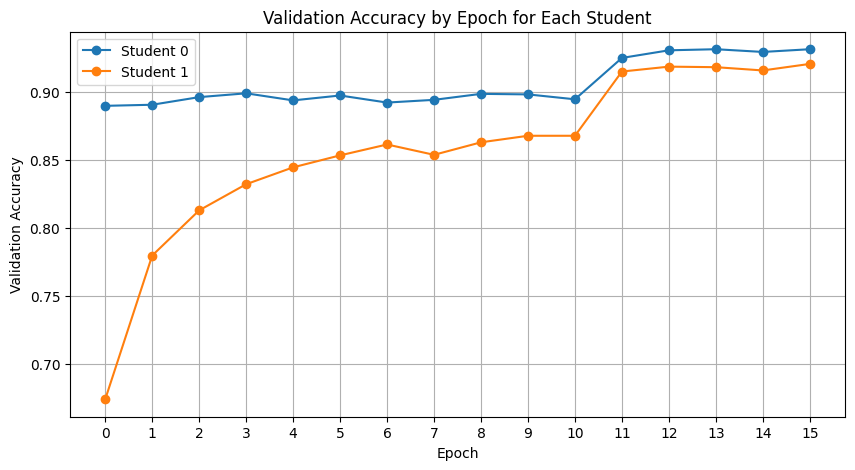

In [58]:
# Load the CSV file into a DataFrame
df = pd.read_csv('checkpoints_student/checkpoints_student_DML/results_student.csv')

# Filter data for each student
student_0 = df[df['Student ID'] == 0]
student_1 = df[df['Student ID'] == 1]

# Convert 'Epoch' column to integers
df['Epoch'] = df['Epoch'].astype(int)

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(student_0['Epoch'], student_0['Valid Accuracy'], label='Student 0', marker='o')
plt.plot(student_1['Epoch'], student_1['Valid Accuracy'], label='Student 1', marker='o')
plt.title('Validation Accuracy by Epoch for Each Student')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.xticks(df['Epoch'].unique())  # Ensure all epochs are included in x-axis
plt.legend()
plt.grid(True)
plt.show()


### Result

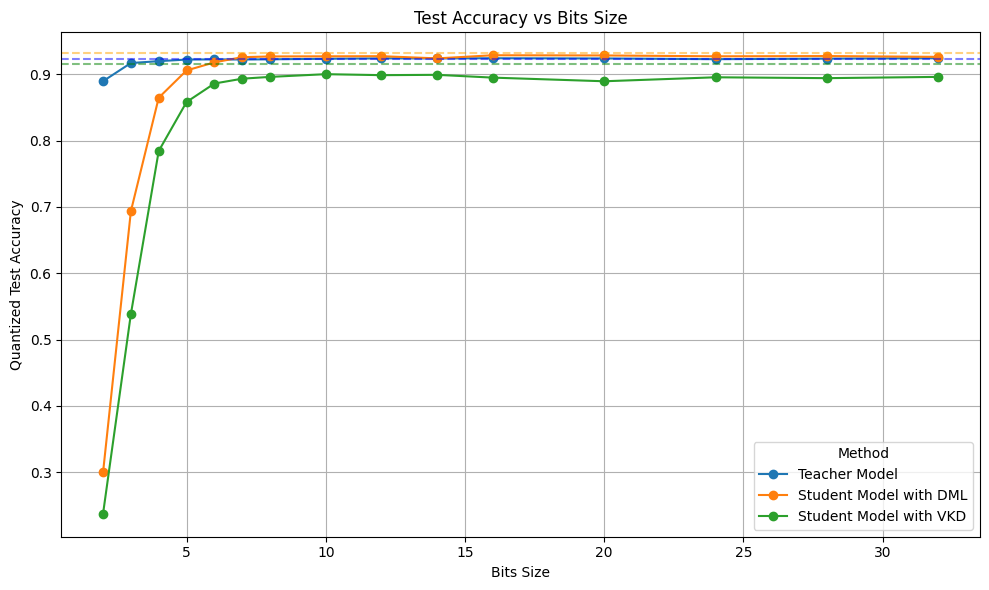

In [28]:
# Load the CSV files
quant_teacher = pd.read_csv("checkpoints_teacher/results_teacher_quantization.csv")
quant_student_dml = pd.read_csv("checkpoints_student/checkpoints_student_DML/results_student_quantization_dml.csv")
quant_student_van = pd.read_csv("checkpoints_student/checkpoints_student_VAN/results_student_quantization_van.csv")

# Plot both lines sharing the same axes
plt.figure(figsize=(10, 6))
plt.plot(quant_teacher["Bits"], quant_teacher["Quantized Test Accuracy"], marker='o', label="Teacher Model")
plt.plot(quant_student_dml["Bits"], quant_student_dml["Quantized Test Accuracy"], marker='o', label="Student Model with DML")
plt.plot(quant_student_van["Bits"], quant_student_van["Quantized Test Accuracy"], marker='o', label="Student Model with VKD")

# Add horizontal lines for original accuracy
plt.axhline(y=0.9225, color='blue', linestyle='--', alpha=0.5)
plt.axhline(y=0.932, color='orange', linestyle='--', alpha=0.5)
plt.axhline(y=0.9152, color='green', linestyle='--', alpha=0.5)

# Add labels and title
plt.title("Test Accuracy vs Bits Size")
plt.xlabel("Bits Size")
plt.ylabel("Quantized Test Accuracy")
plt.grid(True)
plt.legend(title="Method", loc="best")

# Save the plot as PNG
plt.tight_layout()
plt.savefig('images/teacher_student_quant_acc_comparison.png', dpi=500)

# Show the plot
plt.show()


In [30]:
checkpoint = torch.load('checkpoints_student/checkpoints_student_VAN/student_epoch_19.pth')
van_student_net = networks.StudentNetwork(0.0, teacher_net = teacher_net)
van_student_net = student_net.to(fast_device)
van_student_net.load_state_dict(checkpoint)

utils.getLossAccuracyOnDataset(student_net, test_loader, fast_device)

C:\Users\17598\AppData\Local\Temp\ipykernel_9552\774814024.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('checkpoints_student/checkpoints_stude

(0.0, 0.9152)

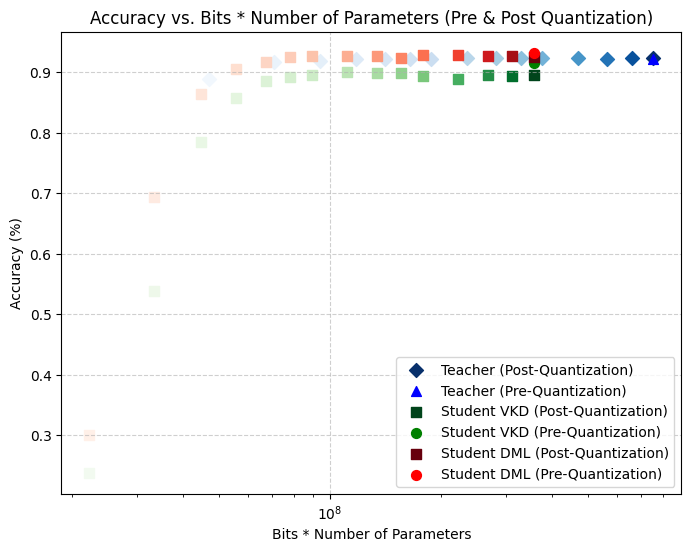

In [47]:
# Load the CSV files
quant_teacher = pd.read_csv("checkpoints_teacher/results_teacher_quantization.csv")
quant_student_dml = pd.read_csv("checkpoints_student/checkpoints_student_DML/results_student_quantization_dml.csv")
quant_student_van = pd.read_csv("checkpoints_student/checkpoints_student_VAN/results_student_quantization_van.csv")

num_parameter_teacher = count_parameters(teacher_net)
quant_teacher["Bits*Num_Parameter"] = quant_teacher['Bits'] * num_parameter_teacher

num_parameter_student = count_parameters(van_student_net)
quant_student_dml["Bits*Num_Parameter"] = quant_student_dml['Bits'] * num_parameter_student
quant_student_van["Bits*Num_Parameter"] = quant_student_van['Bits'] * num_parameter_student

# Define fixed colors for pre-quantization models
pre_student_color_dml = "red"
pre_student_color_van = "green"
pre_teacher_color = "blue"

# Define marker styles
marker_mapping = {
    "pre_student": "o",  # Circle for pre-quantization Student
    "post_student": "s",  # Square for post-quantization Student
    "pre_teacher": "^",  # Triangle for pre-quantization Teacher
    "post_teacher": "D"  # Diamond for post-quantization Teacher
}

# Scatter plots for pre and post-quantization
# Assumed that pre-quantization accuracy data is available; otherwise replace with actual data
pre_quantization_student_van_accuracy = 0.9152
pre_quantization_student_dml_accuracy = 0.932  # Example data
pre_quantization_teacher_accuracy = 0.9225  # Example data

pre_quantization_student_dml_bit_para = 357566784
pre_quantization_teacher_bit_para = 752666944

# Create colormap for bit precisions
cmap_student_dml = plt.cm.Reds
cmap_student_van = plt.cm.Greens
cmap_teacher = plt.cm.Blues
norm_student_dml = plt.Normalize(vmin=min(quant_student_dml['Bits*Num_Parameter'] * 0.5), vmax=max(quant_student_dml['Bits*Num_Parameter']))
norm_student_van = plt.Normalize(vmin=min(quant_student_van['Bits*Num_Parameter'] * 0.5), vmax=max(quant_student_van['Bits*Num_Parameter']))
norm_teacher = plt.Normalize(vmin=min(quant_teacher['Bits*Num_Parameter'] * 0.5), vmax=max(quant_teacher['Bits*Num_Parameter']))

# Define fixed colors for pre-quantization models
pre_student__dml_color = "red"
pre_student__van_color = "green"
pre_teacher_color = "blue"

# Define marker styles
marker_mapping = {
    "pre_student": "o",  # Circle for pre-quantization Student
    "post_student": "s",  # Square for post-quantization Student
    "pre_teacher": "^",  # Triangle for pre-quantization Teacher
    "post_teacher": "D"  # Diamond for post-quantization Teacher
}

fig, ax = plt.subplots(figsize=(8, 6))

# Plot Post-Quantization points
for index, row in quant_teacher.iterrows():
    color_teacher = cmap_teacher(norm_teacher(row['Bits*Num_Parameter']))
    ax.scatter(row['Bits*Num_Parameter'], row['Quantized Test Accuracy'], 
               color=color_teacher, marker=marker_mapping["post_teacher"], s=50, label="Teacher (Post-Quantization)" if index == 0 else "")
ax.scatter(pre_quantization_teacher_bit_para, pre_quantization_teacher_accuracy, 
           color=pre_teacher_color, marker=marker_mapping["pre_teacher"], label="Teacher (Pre-Quantization)", s=50)

for index, row in quant_student_van.iterrows():
    color_student = cmap_student_van(norm_student_van(row['Bits*Num_Parameter']))
    ax.scatter(row['Bits*Num_Parameter'], row['Quantized Test Accuracy'], 
               color=color_student, marker=marker_mapping["post_student"], s=50, label="Student VKD (Post-Quantization)" if index == 0 else "")
ax.scatter(pre_quantization_student_dml_bit_para, pre_quantization_student_van_accuracy, 
           color=pre_student_color_van, marker=marker_mapping["pre_student"], label="Student VKD (Pre-Quantization)", s=50)
   
   
for index, row in quant_student_dml.iterrows():
    color_student = cmap_student_dml(norm_student_dml(row['Bits*Num_Parameter']))
    ax.scatter(row['Bits*Num_Parameter'], row['Quantized Test Accuracy'], 
               color=color_student, marker=marker_mapping["post_student"], s=50, label="Student DML (Post-Quantization)" if index == 0 else "")
ax.scatter(pre_quantization_student_dml_bit_para, pre_quantization_student_dml_accuracy, 
           color=pre_student_color_dml, marker=marker_mapping["pre_student"], label="Student DML (Pre-Quantization)", s=50)  


# Labels and title
plt.xlabel("Bits * Number of Parameters")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy vs. Bits * Number of Parameters (Pre & Post Quantization)")
plt.xscale("log")  # Using log scale for better parameter visualization
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

# Save the plot
if not os.path.exists('images'):
    os.makedirs('images')
image_path = os.path.join('images', "quantization_effects.png")
plt.savefig(image_path, dpi=500)
plt.show()